**Environment Setup & GPU Verification**

In [ ]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("GPU detected:", tf.config.list_physical_devices('GPU'))


TensorFlow version: 2.19.0
GPU detected: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


**Download Dataset from Kaggle**

In [ ]:
from google.colab import files
files.upload()
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


Saving kaggle.json to kaggle.json


**Extract and Verify Dataset Contents**

In [ ]:
# Download and unzip (fixed path)
!kaggle datasets download -d shaunthesheep/microsoft-catsvsdogs-dataset -p /content
!unzip -q /content/microsoft-catsvsdogs-dataset.zip -d /content/catsdogs_raw
!ls -lah /content/catsdogs_raw


Dataset URL: https://www.kaggle.com/datasets/shaunthesheep/microsoft-catsvsdogs-dataset
License(s): other
 85% 671M/788M [00:00<00:00, 1.67GB/s]
100% 788M/788M [00:00<00:00, 1.68GB/s]
total 52K
drwxr-xr-x 3 root root 4.0K Oct 30 01:52  .
drwxr-xr-x 1 root root 4.0K Oct 30 01:52  ..
-rw-r--r-- 1 root root  35K Mar 12  2020 'MSR-LA - 3467.docx'
drwxr-xr-x 4 root root 4.0K Oct 30 01:52  PetImages
-rw-r--r-- 1 root root  104 Mar 12  2020 'readme[1].txt'


**Data Quality Check and Cleanup**

In [ ]:
import glob, os
from PIL import Image

cat_glob = '/content/catsdogs_raw/PetImages/Cat/*.jpg'
dog_glob = '/content/catsdogs_raw/PetImages/Dog/*.jpg'

# Drop unreadable/zero-byte files (the dataset has a few)
def clean_bad_images(pattern):
    removed = 0
    for fp in glob.glob(pattern):
        try:
            if os.path.getsize(fp) == 0:
                os.remove(fp); removed += 1; continue
            with Image.open(fp) as im:
                im.verify()
        except Exception:
            try:
                os.remove(fp); removed += 1
            except: pass
    return removed

removed_c = clean_bad_images(cat_glob)
removed_d = clean_bad_images(dog_glob)

cats = glob.glob(cat_glob)
dogs = glob.glob(dog_glob)
print(f"Removed (bad): cats={removed_c}, dogs={removed_d}")
print("Cats:", len(cats))
print("Dogs:", len(dogs))


/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Removed (bad): cats=1, dogs=1
Cats: 12499
Dogs: 12499


**Create Balanced Splits — Experiment A (N_train = 1,000)**

In [86]:
import os, glob, random, shutil, pathlib

random.seed(42)

RAW_CAT = '/content/catsdogs_raw/PetImages/Cat/*.jpg'
RAW_DOG = '/content/catsdogs_raw/PetImages/Dog/*.jpg'

cats = sorted(glob.glob(RAW_CAT))
dogs = sorted(glob.glob(RAW_DOG))

def make_dirs(root):
    for split in ['train','val','test']:
        for cls in ['cats','dogs']:
            pathlib.Path(f'{root}/{split}/{cls}').mkdir(parents=True, exist_ok=True)

ROOT = '/content/data_small'   # destination for the 1k experiment
!rm -rf {ROOT}
make_dirs(ROOT)

# Target counts per split (PER CLASS)
# -> totals: train=1000, val=500, test=500
split_sizes = {'train': 500, 'val': 250, 'test': 250}

def take_and_copy(src_list, split_sizes, cls):
    picks = src_list.copy()
    random.shuffle(picks)
    i = 0
    for split, n in split_sizes.items():
        chunk = picks[i:i+n]; i += n
        for fp in chunk:
            shutil.copy(fp, f'{ROOT}/{split}/{cls}/')

# Build cats/dogs splits
take_and_copy(cats, split_sizes, 'cats')
take_and_copy(dogs, split_sizes, 'dogs')

# Quick counts + summary
def count_split(root, split, cls):
    return len(glob.glob(f'{root}/{split}/{cls}/*.jpg'))

summary = {}
for split in ['train','val','test']:
    c = count_split(ROOT, split, 'cats')
    d = count_split(ROOT, split, 'dogs')
    summary[split] = (c, d, c+d)
    print(f'{split:<5}: cats={c:4d}, dogs={d:4d}, total={c+d:4d}')

print("\nExperiment A summary:")
print(" - Training total:", summary['train'][2], "(cats =", summary['train'][0], ", dogs =", summary['train'][1], ")")
print(" - Validation total:", summary['val'][2],  "(cats =", summary['val'][0],  ", dogs =", summary['val'][1],  ")")
print(" - Test total:", summary['test'][2],       "(cats =", summary['test'][0], ", dogs =", summary['test'][1], ")")


train: cats= 500, dogs= 500, total=1000
val  : cats= 250, dogs= 250, total= 500
test : cats= 250, dogs= 250, total= 500

Experiment A summary:
 - Training total: 1000 (cats = 500 , dogs = 500 )
 - Validation total: 500 (cats = 250 , dogs = 250 )
 - Test total: 500 (cats = 250 , dogs = 250 )


**Image Preprocessing and Data Generators**

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = (150, 150)
BATCH = 32
ROOT = "/content/data_small"

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    f"{ROOT}/train", target_size=IMG_SIZE, batch_size=BATCH,
    class_mode='binary'
)
val_gen = val_test_datagen.flow_from_directory(
    f"{ROOT}/val", target_size=IMG_SIZE, batch_size=BATCH,
    class_mode='binary', shuffle=False
)
test_gen = val_test_datagen.flow_from_directory(
    f"{ROOT}/test", target_size=IMG_SIZE, batch_size=BATCH,
    class_mode='binary', shuffle=False
)

print("Class indices:", train_gen.class_indices)  # {'cats':0,'dogs':1}


Found 1000 images belonging to 2 classes.
Found 500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.
Class indices: {'cats': 0, 'dogs': 1}


**Define and Compile Model A — From-Scratch CNN**

In [82]:

from tensorflow.keras import layers, models, optimizers

model_scratch = models.Sequential([
    layers.Input(shape=(*IMG_SIZE, 3)),

    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(512, activation='relu'),
    layers.Dense(1, activation='sigmoid')   # binary output
])

model_scratch.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Print concise model summary
model_scratch.summary()


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)              │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_11 (Flatten)            │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 512)            │    18,940,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,034,177 (72.61 MB)

 Trainable params: 19,034,177 (72.61 MB)

 Non-trainable params: 0 (0.00 B)

**Train Model A — From-Scratch CNN (Experiment A: N = 1 000)**

In [84]:

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

ckpt_path = "/content/model_scratch_best.keras"

callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True),
    ModelCheckpoint(ckpt_path, monitor='val_accuracy', save_best_only=True)
]

history_scratch = model_scratch.fit(
    train_gen,
    validation_data=val_gen,
    epochs=15,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 284ms/step - accuracy: 0.4858 - loss: 0.7164 - val_accuracy: 0.5700 - val_loss: 0.6810
Epoch 2/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 235ms/step - accuracy: 0.5902 - loss: 0.6796 - val_accuracy: 0.6140 - val_loss: 0.6613
Epoch 3/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 205ms/step - accuracy: 0.6169 - loss: 0.6525 - val_accuracy: 0.5920 - val_loss: 0.6671
Epoch 4/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 233ms/step - accuracy: 0.6207 - loss: 0.6620 - val_accuracy: 0.6220 - val_loss: 0.6276
Epoch 5/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 233ms/step - accuracy: 0.6227 - loss: 0.6435 - val_accuracy: 0.6540 - val_loss: 0.6208
Epoch 6/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 234ms/step - accuracy: 0.6414 - loss: 0.6280 - val_accuracy: 0.6560 - val_loss: 0.6282
Epoch 7/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 204ms/step - accuracy: 0.6506 - loss: 0.6292 - val_accuracy: 0.6360 - val_loss: 0.6059
Epoch 8/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 206ms/step - accuracy: 0.6810 - loss: 0.6091 - val_accuracy: 0

**Evaluate Model A — From-Scratch CNN (Experiment A: N = 1 000)**

In [85]:
# Test evaluation
test_loss, test_acc = model_scratch.evaluate(test_gen, verbose=0)
val_acc_best = max(history_scratch.history['val_accuracy'])
print(f"Validation Accuracy (best): {val_acc_best:.3f}")
print(f"Test Accuracy: {test_acc:.3f}")

# Store for report table later
results_expt1 = {
    "model": "from_scratch",
    "train_samples": 1000,
    "val_samples": 500,
    "test_samples": 500,
    "val_acc": float(val_acc_best),
    "test_acc": float(test_acc)
}
results_expt1


Validation Accuracy (best): 0.706
Test Accuracy: 0.740


{'model': 'from_scratch',
 'train_samples': 1000,
 'val_samples': 500,
 'test_samples': 500,
 'val_acc': 0.7059999704360962,
 'test_acc': 0.7400000095367432}

**Training Curves — From-Scratch CNN (Experiment A: 1K)**

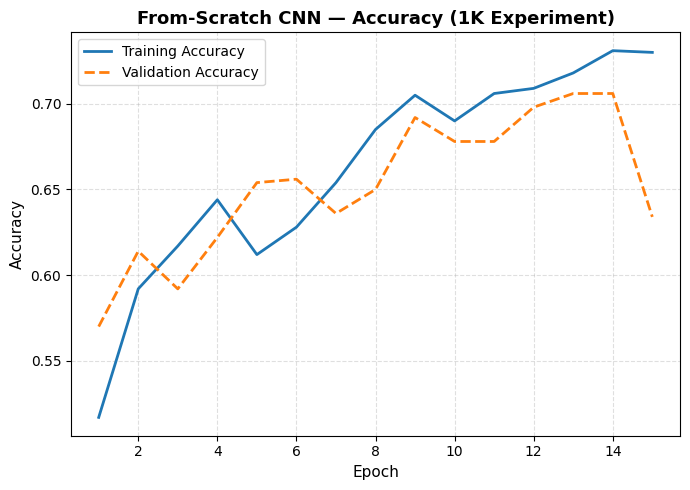

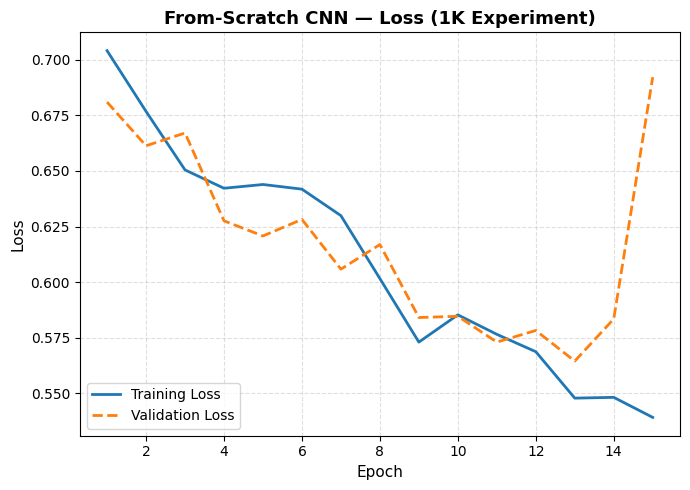

In [89]:
import matplotlib.pyplot as plt

hist = history_scratch.history
epochs = range(1, len(hist['accuracy']) + 1)

# --- Accuracy Curve ---
plt.figure(figsize=(7, 5))
plt.plot(epochs, hist['accuracy'], label='Training Accuracy', linewidth=2)
plt.plot(epochs, hist['val_accuracy'], label='Validation Accuracy', linewidth=2, linestyle='--')
plt.title('From-Scratch CNN — Accuracy (1K Experiment)', fontsize=13, fontweight='bold')
plt.xlabel('Epoch', fontsize=11)
plt.ylabel('Accuracy', fontsize=11)
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()

# --- Loss Curve ---
plt.figure(figsize=(7, 5))
plt.plot(epochs, hist['loss'], label='Training Loss', linewidth=2)
plt.plot(epochs, hist['val_loss'], label='Validation Loss', linewidth=2, linestyle='--')
plt.title('From-Scratch CNN — Loss (1K Experiment)', fontsize=13, fontweight='bold')
plt.xlabel('Epoch', fontsize=11)
plt.ylabel('Loss', fontsize=11)
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()

**Evaluation Metrics — Confusion Matrix and Classification Report (1K Experiment)**

In [90]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# Predict class probabilities
probs = model_scratch.predict(test_gen, verbose=0).ravel()
preds = (probs >= 0.5).astype(int)

# True labels from generator
true = test_gen.classes

# Confusion matrix and report
cm = confusion_matrix(true, preds)
report = classification_report(true, preds, target_names=['cat', 'dog'])

print("Confusion Matrix:\n", cm)
print("\nClassification Report:\n", report)

Confusion Matrix:
 [[187  63]
 [ 67 183]]

Classification Report:
               precision    recall  f1-score   support

         cat       0.74      0.75      0.74       250
         dog       0.74      0.73      0.74       250

    accuracy                           0.74       500
   macro avg       0.74      0.74      0.74       500
weighted avg       0.74      0.74      0.74       500



**Experiment B (10K Training Samples)**

In [91]:
import os, glob, random, shutil, pathlib

random.seed(42)

# Reuse same val/test directories from previous experiment
VAL_DIR  = "/content/data_small/val"
TEST_DIR = "/content/data_small/test"

# Create destination for 10K training dataset
ROOT_MED = "/content/data_medium"
TRAIN_MED = f"{ROOT_MED}/train"
!rm -rf {ROOT_MED}
pathlib.Path(f"{TRAIN_MED}/cats").mkdir(parents=True, exist_ok=True)
pathlib.Path(f"{TRAIN_MED}/dogs").mkdir(parents=True, exist_ok=True)

# Collect all available raw images
raw_cats = sorted(glob.glob('/content/catsdogs_raw/PetImages/Cat/*.jpg'))
raw_dogs = sorted(glob.glob('/content/catsdogs_raw/PetImages/Dog/*.jpg'))

# Exclude images used in val/test
used_cats = set(glob.glob(f"{VAL_DIR}/cats/*.jpg") + glob.glob(f"{TEST_DIR}/cats/*.jpg"))
used_dogs = set(glob.glob(f"{VAL_DIR}/dogs/*.jpg") + glob.glob(f"{TEST_DIR}/dogs/*.jpg"))

avail_cats = [p for p in raw_cats if p not in used_cats]
avail_dogs = [p for p in raw_dogs if p not in used_dogs]

# Target per class for training (total = 10K)
n_per_class = 5000
random.shuffle(avail_cats)
random.shuffle(avail_dogs)
pick_cats = avail_cats[:n_per_class]
pick_dogs = avail_dogs[:n_per_class]

# Copy selected files
for fp in pick_cats:
    shutil.copy(fp, f"{TRAIN_MED}/cats/")
for fp in pick_dogs:
    shutil.copy(fp, f"{TRAIN_MED}/dogs/")

# Verify counts
c = len(glob.glob(f"{TRAIN_MED}/cats/*.jpg"))
d = len(glob.glob(f"{TRAIN_MED}/dogs/*.jpg"))
print(f"TRAIN (medium): cats={c}, dogs={d}, total={c+d}")

# Confirm val/test sets unchanged
cv = len(glob.glob(f"{VAL_DIR}/cats/*.jpg"))
dv = len(glob.glob(f"{VAL_DIR}/dogs/*.jpg"))
ct = len(glob.glob(f"{TEST_DIR}/cats/*.jpg"))
dt = len(glob.glob(f"{TEST_DIR}/dogs/*.jpg"))

print(f"VAL : cats={cv}, dogs={dv}, total={cv+dv}")
print(f"TEST: cats={ct}, dogs={dt}, total={ct+dt}")

TRAIN (medium): cats=5000, dogs=5000, total=10000
VAL : cats=250, dogs=250, total=500
TEST: cats=250, dogs=250, total=500


**Image Generators — Experiment B (10K Training Samples)**

In [92]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = (150, 150)
BATCH = 32

# Training generator with augmentation
train_datagen_med = ImageDataGenerator(
    rescale=1.0 / 255.0,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode="nearest"
)

# Validation/Test generators (no augmentation)
val_test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

# Build generators
train_gen_med = train_datagen_med.flow_from_directory(
    f"{ROOT_MED}/train",
    target_size=IMG_SIZE,
    batch_size=BATCH,
    class_mode="binary"
)

val_gen = val_test_datagen.flow_from_directory(
    "/content/data_small/val",
    target_size=IMG_SIZE,
    batch_size=BATCH,
    class_mode="binary",
    shuffle=False
)

test_gen = val_test_datagen.flow_from_directory(
    "/content/data_small/test",
    target_size=IMG_SIZE,
    batch_size=BATCH,
    class_mode="binary",
    shuffle=False
)

Found 10000 images belonging to 2 classes.
Found 500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


**Train Model A — From-Scratch CNN (Experiment B: 10K)**

In [93]:
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define model
model_scratch_med = models.Sequential([
    layers.Input(shape=(*IMG_SIZE, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(512, activation='relu'),
    layers.Dense(1, activation='sigmoid')   # binary output
])

# Compile
model_scratch_med.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Callbacks
ckpt_path_med = "/content/model_scratch_med_best.keras"
callbacks_med = [
    EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True),
    ModelCheckpoint(ckpt_path_med, monitor='val_accuracy', save_best_only=True)
]

# Train
history_scratch_med = model_scratch_med.fit(
    train_gen_med,
    validation_data=val_gen,   # same val set for fair comparison
    epochs=15,
    callbacks=callbacks_med,
    verbose=1
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 65s 198ms/step - accuracy: 0.5738 - loss: 0.6767 - val_accuracy: 0.7080 - val_loss: 0.5685
Epoch 2/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 59s 187ms/step - accuracy: 0.7030 - loss: 0.5746 - val_accuracy: 0.7060 - val_loss: 0.5841
Epoch 3/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 59s 190ms/step - accuracy: 0.7121 - loss: 0.5538 - val_accuracy: 0.7540 - val_loss: 0.5045
Epoch 4/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 60s 190ms/step - accuracy: 0.7496 - loss: 0.5142 - val_accuracy: 0.7820 - val_loss: 0.4653
Epoch 5/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 59s 187ms/step - accuracy: 0.7633 - loss: 0.4870 - val_accuracy: 0.7720 - val_loss: 0.4624
Epoch 6/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 60s 191ms/step - accuracy: 0.7731 - loss: 0.4796 - val_accuracy: 0.7920 - val_loss: 0.4202
Epoch 7/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 59s 189ms/step - accuracy: 0.7718 - loss: 0.4787 - val_accuracy: 0.8100 - val_loss: 0.4109
Epoch 8/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 60s 190ms/step - accuracy: 0.7918 - loss: 0

**Evaluate Model A — From-Scratch CNN (Experiment B: 10K)**

In [94]:
# Metrics
test_loss_med, test_acc_med = model_scratch_med.evaluate(test_gen, verbose=0)
val_acc_med = max(history_scratch_med.history['val_accuracy'])
print(f"[From-scratch, 10k train] Best Val Acc: {val_acc_med:.3f}")
print(f"[From-scratch, 10k train] Test Acc:    {test_acc_med:.3f}")

results_expt2 = {
    "model": "from_scratch",
    "train_samples": 10000,
    "val_samples": 500,
    "test_samples": 500,
    "val_acc": float(val_acc_med),
    "test_acc": float(test_acc_med)
}
results_expt2


[From-scratch, 10k train] Best Val Acc: 0.856
[From-scratch, 10k train] Test Acc:    0.842


{'model': 'from_scratch',
 'train_samples': 10000,
 'val_samples': 500,
 'test_samples': 500,
 'val_acc': 0.8560000061988831,
 'test_acc': 0.8420000076293945}

**Training Curves — From-Scratch CNN (10K Experiment)**

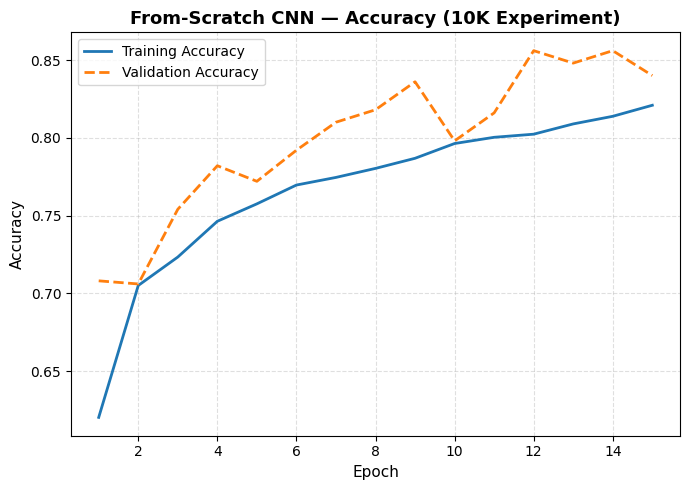

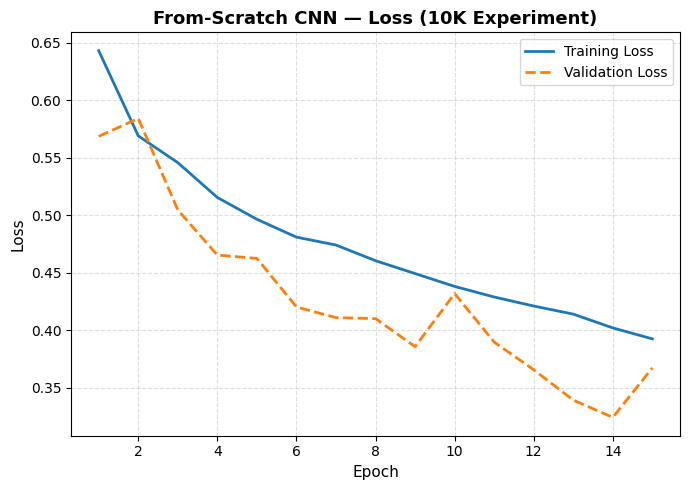

In [95]:
import matplotlib.pyplot as plt

h = history_scratch_med.history
epochs = range(1, len(h['accuracy']) + 1)

# --- Accuracy Curve ---
plt.figure(figsize=(7, 5))
plt.plot(epochs, h['accuracy'], label='Training Accuracy', linewidth=2)
plt.plot(epochs, h['val_accuracy'], label='Validation Accuracy', linewidth=2, linestyle='--')
plt.title('From-Scratch CNN — Accuracy (10K Experiment)', fontsize=13, fontweight='bold')
plt.xlabel('Epoch', fontsize=11)
plt.ylabel('Accuracy', fontsize=11)
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()

# --- Loss Curve ---
plt.figure(figsize=(7, 5))
plt.plot(epochs, h['loss'], label='Training Loss', linewidth=2)
plt.plot(epochs, h['val_loss'], label='Validation Loss', linewidth=2, linestyle='--')
plt.title('From-Scratch CNN — Loss (10K Experiment)', fontsize=13, fontweight='bold')
plt.xlabel('Epoch', fontsize=11)
plt.ylabel('Loss', fontsize=11)
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()

**Confusion Matrix & Classification Report (10K)**

In [96]:

import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# Predict probabilities and threshold
probs_med = model_scratch_med.predict(test_gen, verbose=0).ravel()
preds_med = (probs_med >= 0.5).astype(int)

# True labels
true = test_gen.classes

# Compute metrics
cm_med = confusion_matrix(true, preds_med)
report_med = classification_report(true, preds_med, target_names=['cat', 'dog'])

# Display results
print("Confusion Matrix (10K Experiment):\n", cm_med)
print("\nClassification Report (10K Experiment):\n", report_med)

Confusion Matrix (10K Experiment):
 [[189  61]
 [ 18 232]]

Classification Report (10K Experiment):
               precision    recall  f1-score   support

         cat       0.91      0.76      0.83       250
         dog       0.79      0.93      0.85       250

    accuracy                           0.84       500
   macro avg       0.85      0.84      0.84       500
weighted avg       0.85      0.84      0.84       500



**Experiment C (15K Training Samples)**

In [97]:

import os, glob, random, shutil, pathlib
random.seed(42)

VAL_DIR  = "/content/data_small/val"
TEST_DIR = "/content/data_small/test"

ROOT_15K  = "/content/data_15k"
TRAIN_15K = f"{ROOT_15K}/train"

# Reset destination
!rm -rf {ROOT_15K}
pathlib.Path(f"{TRAIN_15K}/cats").mkdir(parents=True, exist_ok=True)
pathlib.Path(f"{TRAIN_15K}/dogs").mkdir(parents=True, exist_ok=True)

# All raw images
raw_cats = sorted(glob.glob('/content/catsdogs_raw/PetImages/Cat/*.jpg'))
raw_dogs = sorted(glob.glob('/content/catsdogs_raw/PetImages/Dog/*.jpg'))

# Exclude images used in val/test
used_cats = set(glob.glob(f"{VAL_DIR}/cats/*.jpg") + glob.glob(f"{TEST_DIR}/cats/*.jpg"))
used_dogs = set(glob.glob(f"{VAL_DIR}/dogs/*.jpg") + glob.glob(f"{TEST_DIR}/dogs/*.jpg"))

avail_cats = [p for p in raw_cats if p not in used_cats]
avail_dogs = [p for p in raw_dogs if p not in used_dogs]

# Target per class (total = 15,000)
n_per_class = 7500
random.shuffle(avail_cats); pick_cats = avail_cats[:n_per_class]
random.shuffle(avail_dogs); pick_dogs = avail_dogs[:n_per_class]

# Copy selections
for fp in pick_cats:
    shutil.copy(fp, f"{TRAIN_15K}/cats/")
for fp in pick_dogs:
    shutil.copy(fp, f"{TRAIN_15K}/dogs/")

# Verify counts
c = len(glob.glob(f"{TRAIN_15K}/cats/*.jpg"))
d = len(glob.glob(f"{TRAIN_15K}/dogs/*.jpg"))
print(f"TRAIN (15K): cats={c}, dogs={d}, total={c+d}")

# Confirm val/test are unchanged
cv = len(glob.glob(f"{VAL_DIR}/cats/*.jpg"))
dv = len(glob.glob(f"{VAL_DIR}/dogs/*.jpg"))
ct = len(glob.glob(f"{TEST_DIR}/cats/*.jpg"))
dt = len(glob.glob(f"{TEST_DIR}/dogs/*.jpg"))
print(f"VAL : cats={cv}, dogs={dv}, total={cv+dv}")
print(f"TEST: cats={ct}, dogs={dt}, total={ct+dt}")

TRAIN (15K): cats=7500, dogs=7500, total=15000
VAL : cats=250, dogs=250, total=500
TEST: cats=250, dogs=250, total=500


**Image Generators — Experiment C (15K Training Samples)**

In [99]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = (150, 150)
BATCH = 32

train_datagen_15k = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_test_datagen = ImageDataGenerator(rescale=1./255)

train_gen_15k = train_datagen_15k.flow_from_directory(
    f"{ROOT_15K}/train", target_size=IMG_SIZE, batch_size=BATCH,
    class_mode='binary'
)
val_gen = val_test_datagen.flow_from_directory(
    VAL_DIR, target_size=IMG_SIZE, batch_size=BATCH,
    class_mode='binary', shuffle=False
)
test_gen = val_test_datagen.flow_from_directory(
    TEST_DIR, target_size=IMG_SIZE, batch_size=BATCH,
    class_mode='binary', shuffle=False
)


Found 15000 images belonging to 2 classes.
Found 500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


**Train Model A — From-Scratch CNN (Experiment C: 15K)**

In [ ]:
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

model_scratch_15k = models.Sequential([
    layers.Input(shape=(*IMG_SIZE, 3)),
    layers.Conv2D(32, (3,3), activation='relu'), layers.MaxPooling2D(2,2),
    layers.Conv2D(64, (3,3), activation='relu'), layers.MaxPooling2D(2,2),
    layers.Conv2D(128,(3,3), activation='relu'), layers.MaxPooling2D(2,2),
    layers.Flatten(), layers.Dropout(0.5),
    layers.Dense(512, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model_scratch_15k.compile(optimizer=optimizers.Adam(1e-4),
                          loss='binary_crossentropy', metrics=['accuracy'])

ckpt_scratch_15k = "/content/model_scratch_15k_best.keras"
callbacks_15k = [
    EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True),
    ModelCheckpoint(ckpt_scratch_15k, monitor='val_accuracy', save_best_only=True)
]

history_scratch_15k = model_scratch_15k.fit(
    train_gen_15k, validation_data=val_gen, epochs=15, callbacks=callbacks_15k, verbose=1
)


Epoch 1/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 94s 194ms/step - accuracy: 0.5796 - loss: 0.6615 - val_accuracy: 0.7220 - val_loss: 0.5460
Epoch 2/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 89s 189ms/step - accuracy: 0.7119 - loss: 0.5594 - val_accuracy: 0.7620 - val_loss: 0.5061
Epoch 3/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 88s 188ms/step - accuracy: 0.7374 - loss: 0.5266 - val_accuracy: 0.7840 - val_loss: 0.4521
Epoch 4/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 88s 188ms/step - accuracy: 0.7627 - loss: 0.4933 - val_accuracy: 0.7960 - val_loss: 0.4298
Epoch 5/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 87s 185ms/step - accuracy: 0.7674 - loss: 0.4737 - val_accuracy: 0.7940 - val_loss: 0.4203
Epoch 6/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 88s 189ms/step - accuracy: 0.7807 - loss: 0.4578 - val_accuracy: 0.8320 - val_loss: 0.3814
Epoch 7/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 87s 186ms/step - accuracy: 0.7945 - loss: 0.4364 - val_accuracy: 0.8280 - val_loss: 0.3900
Epoch 8/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 88s 188ms/step - accuracy: 0.8047 - loss: 0

**Evaluate Model A — From-Scratch CNN (Experiment C: 15K)**

In [101]:
# Evaluate on test data
test_loss_15k, test_acc_15k = model_scratch_15k.evaluate(test_gen, verbose=0)
val_acc_15k = max(history_scratch_15k.history['val_accuracy'])

print(f"[From-Scratch, 15K Train] Best Validation Accuracy: {val_acc_15k:.3f}")
print(f"[From-Scratch, 15K Train] Test Accuracy:           {test_acc_15k:.3f}")

# Store results for the summary table
results_expt3 = {
    "model": "from_scratch",
    "train_samples": 15000,
    "val_samples": 500,
    "test_samples": 500,
    "val_acc": float(val_acc_15k),
    "test_acc": float(test_acc_15k)
}

results_expt3

[From-Scratch, 15K Train] Best Validation Accuracy: 0.876
[From-Scratch, 15K Train] Test Accuracy:           0.860


{'model': 'from_scratch',
 'train_samples': 15000,
 'val_samples': 500,
 'test_samples': 500,
 'val_acc': 0.8759999871253967,
 'test_acc': 0.8600000143051147}

**Training Curves — From-Scratch CNN (15K Experiment)**

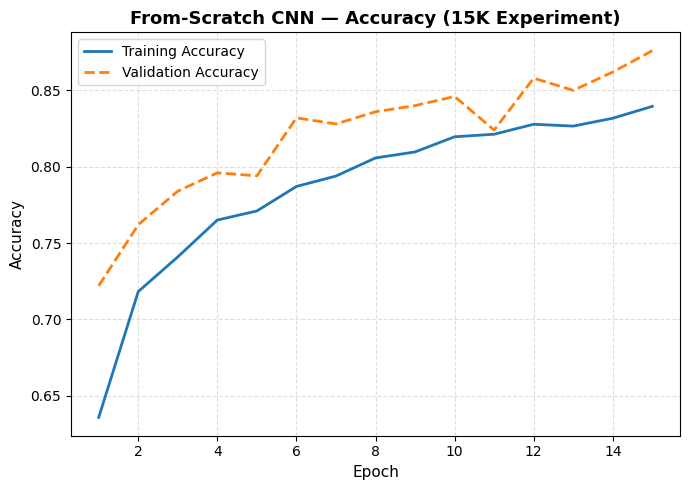

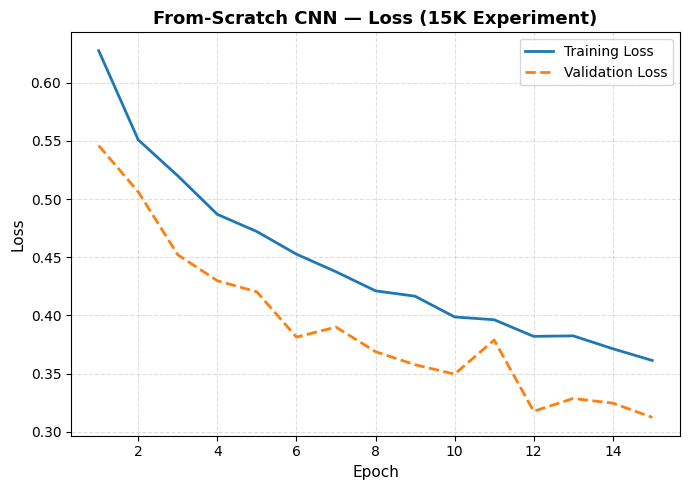

In [102]:
import matplotlib.pyplot as plt

h = history_scratch_15k.history
epochs = range(1, len(h['accuracy']) + 1)

# --- Accuracy ---
plt.figure(figsize=(7, 5))
plt.plot(epochs, h['accuracy'],     label='Training Accuracy',   linewidth=2)
plt.plot(epochs, h['val_accuracy'], label='Validation Accuracy', linewidth=2, linestyle='--')
plt.title('From-Scratch CNN — Accuracy (15K Experiment)', fontsize=13, fontweight='bold')
plt.xlabel('Epoch', fontsize=11)
plt.ylabel('Accuracy', fontsize=11)
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()

# --- Loss ---
plt.figure(figsize=(7, 5))
plt.plot(epochs, h['loss'],     label='Training Loss',   linewidth=2)
plt.plot(epochs, h['val_loss'], label='Validation Loss', linewidth=2, linestyle='--')
plt.title('From-Scratch CNN — Loss (15K Experiment)', fontsize=13, fontweight='bold')
plt.xlabel('Epoch', fontsize=11)
plt.ylabel('Loss',   fontsize=11)
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()

**Evaluation Metrics — Confusion Matrix and Classification Report (15K Experiment)**

In [103]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# Predictions on test data
probs_15k = model_scratch_15k.predict(test_gen, verbose=0).ravel()
preds_15k = (probs_15k >= 0.5).astype(int)
true = test_gen.classes

# Compute metrics
cm_15k = confusion_matrix(true, preds_15k)
report_15k = classification_report(true, preds_15k, target_names=['cat', 'dog'])

# Display results
print("Confusion Matrix (15K Experiment):\n", cm_15k)
print("\nClassification Report (15K Experiment):\n", report_15k)

Confusion Matrix (15K Experiment):
 [[228  22]
 [ 48 202]]

Classification Report (15K Experiment):
               precision    recall  f1-score   support

         cat       0.83      0.91      0.87       250
         dog       0.90      0.81      0.85       250

    accuracy                           0.86       500
   macro avg       0.86      0.86      0.86       500
weighted avg       0.86      0.86      0.86       500



**Experiment D (20K Training Samples)**

In [104]:
import os, glob, random, shutil, pathlib
random.seed(42)

VAL_DIR  = "/content/data_small/val"
TEST_DIR = "/content/data_small/test"

ROOT_20K  = "/content/data_20k"
TRAIN_20K = f"{ROOT_20K}/train"

# Reset destination
!rm -rf {ROOT_20K}
pathlib.Path(f"{TRAIN_20K}/cats").mkdir(parents=True, exist_ok=True)
pathlib.Path(f"{TRAIN_20K}/dogs").mkdir(parents=True, exist_ok=True)

# All raw images
raw_cats = sorted(glob.glob('/content/catsdogs_raw/PetImages/Cat/*.jpg'))
raw_dogs = sorted(glob.glob('/content/catsdogs_raw/PetImages/Dog/*.jpg'))

# Exclude validation/test images
used_cats = set(glob.glob(f"{VAL_DIR}/cats/*.jpg") + glob.glob(f"{TEST_DIR}/cats/*.jpg"))
used_dogs = set(glob.glob(f"{VAL_DIR}/dogs/*.jpg") + glob.glob(f"{TEST_DIR}/dogs/*.jpg"))

avail_cats = [p for p in raw_cats if p not in used_cats]
avail_dogs = [p for p in raw_dogs if p not in used_dogs]

# Target per class (total = 20,000)
n_per_class = 10000
random.shuffle(avail_cats); pick_cats = avail_cats[:n_per_class]
random.shuffle(avail_dogs); pick_dogs = avail_dogs[:n_per_class]

# Copy selected files
for fp in pick_cats:
    shutil.copy(fp, f"{TRAIN_20K}/cats/")
for fp in pick_dogs:
    shutil.copy(fp, f"{TRAIN_20K}/dogs/")

# Verify counts
c = len(glob.glob(f"{TRAIN_20K}/cats/*.jpg"))
d = len(glob.glob(f"{TRAIN_20K}/dogs/*.jpg"))
print(f"TRAIN (20K): cats={c}, dogs={d}, total={c+d}")

# Confirm val/test sets unchanged
cv = len(glob.glob(f"{VAL_DIR}/cats/*.jpg"))
dv = len(glob.glob(f"{VAL_DIR}/dogs/*.jpg"))
ct = len(glob.glob(f"{TEST_DIR}/cats/*.jpg"))
dt = len(glob.glob(f"{TEST_DIR}/dogs/*.jpg"))
print(f"VAL : cats={cv}, dogs={dv}, total={cv+dv}")
print(f"TEST: cats={ct}, dogs={dt}, total={ct+dt}")

TRAIN (20K): cats=10000, dogs=10000, total=20000
VAL : cats=250, dogs=250, total=500
TEST: cats=250, dogs=250, total=500


**Image Generators — Experiment D (20K Training Samples)**

In [106]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = (150, 150)
BATCH = 32

train_datagen_large = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_test_datagen = ImageDataGenerator(rescale=1./255)

train_gen_large = train_datagen_large.flow_from_directory(
    f"{ROOT_LARGE}/train", target_size=IMG_SIZE, batch_size=BATCH,
    class_mode='binary'
)
val_gen = val_test_datagen.flow_from_directory(
    f"/content/data_small/val", target_size=IMG_SIZE, batch_size=BATCH,
    class_mode='binary', shuffle=False
)
test_gen = val_test_datagen.flow_from_directory(
    f"/content/data_small/test", target_size=IMG_SIZE, batch_size=BATCH,
    class_mode='binary', shuffle=False
)


Found 20000 images belonging to 2 classes.
Found 500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


**Train Model A — From-Scratch CNN (Experiment D: 20K)**

In [107]:
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define model
model_scratch_large = models.Sequential([
    layers.Input(shape=(*IMG_SIZE, 3)),

    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(512, activation='relu'),
    layers.Dense(1, activation='sigmoid')   # binary output
])

# Compile
model_scratch_large.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Callbacks
ckpt_path_large = "/content/model_scratch_large_best.keras"
callbacks_large = [
    EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True),
    ModelCheckpoint(ckpt_path_large, monitor='val_accuracy', save_best_only=True)
]

# Train
history_scratch_large = model_scratch_large.fit(
    train_gen_20k,
    validation_data=val_gen,
    epochs=15,
    callbacks=callbacks_large,
    verbose=1
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
425/625 ━━━━━━━━━━━━━━━━━━━━ 36s 185ms/step - accuracy: 0.5648 - loss: 0.6823

/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


625/625 ━━━━━━━━━━━━━━━━━━━━ 122s 190ms/step - accuracy: 0.5848 - loss: 0.6678 - val_accuracy: 0.7380 - val_loss: 0.5320
Epoch 2/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 117s 186ms/step - accuracy: 0.7216 - loss: 0.5498 - val_accuracy: 0.7880 - val_loss: 0.4608
Epoch 3/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 117s 188ms/step - accuracy: 0.7494 - loss: 0.5140 - val_accuracy: 0.7960 - val_loss: 0.4227
Epoch 4/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 118s 188ms/step - accuracy: 0.7678 - loss: 0.4825 - val_accuracy: 0.8120 - val_loss: 0.4112
Epoch 5/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 116s 186ms/step - accuracy: 0.7753 - loss: 0.4664 - val_accuracy: 0.8020 - val_loss: 0.4144
Epoch 6/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 117s 188ms/step - accuracy: 0.7988 - loss: 0.4369 - val_accuracy: 0.8320 - val_loss: 0.3780
Epoch 7/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 116s 186ms/step - accuracy: 0.8007 - loss: 0.4312 - val_accuracy: 0.8180 - val_loss: 0.4005
Epoch 8/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 117s 187ms/step - accuracy: 0.8081 - loss: 0.41

**Evaluate Model A — From-Scratch CNN (Experiment D: 20K)**

In [109]:
# Evaluate on test data (store loss for heatmap compatibility)
test_loss_l, test_acc_l = model_scratch_large.evaluate(test_gen, verbose=0)
val_acc_l = max(history_scratch_large.history['val_accuracy'])

print(f"[From-Scratch, 20K Train] Best Validation Accuracy: {val_acc_l:.3f}")
print(f"[From-Scratch, 20K Train] Test Accuracy:           {test_acc_l:.3f}")
print(f"[From-Scratch, 20K Train] Test Loss:               {test_loss_l:.3f}")

# Store results for the summary table (expected key name for 20K = results_expt3)
results_expt3 = {
    "model": "from_scratch",
    "train_samples": 20000,
    "val_samples": 500,
    "test_samples": 500,
    "val_acc": float(val_acc_l),
    "test_acc": float(test_acc_l)
}

results_expt3

[From-Scratch, 20K Train] Best Validation Accuracy: 0.872
[From-Scratch, 20K Train] Test Accuracy:           0.876
[From-Scratch, 20K Train] Test Loss:               0.284


{'model': 'from_scratch',
 'train_samples': 20000,
 'val_samples': 500,
 'test_samples': 500,
 'val_acc': 0.871999979019165,
 'test_acc': 0.8759999871253967}

**Training Curves — From-Scratch CNN (20K Experiment)**

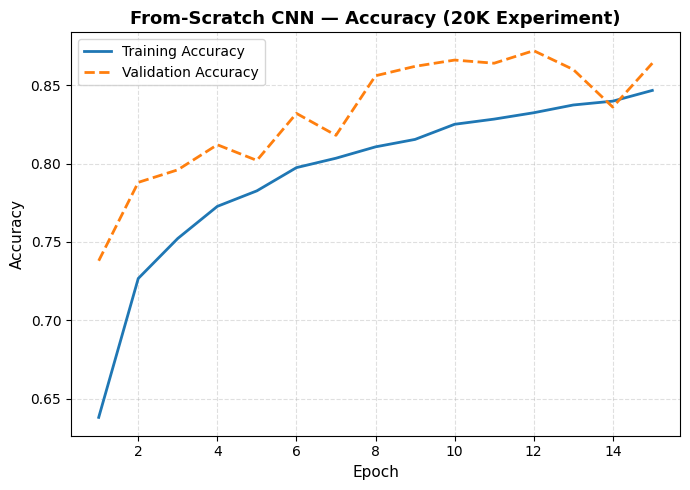

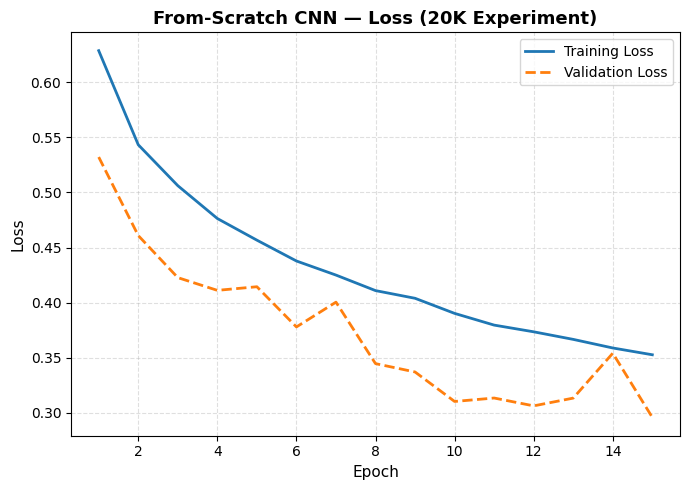

In [110]:
import matplotlib.pyplot as plt

h = history_scratch_large.history
epochs = range(1, len(h['accuracy']) + 1)

# --- Accuracy ---
plt.figure(figsize=(7, 5))
plt.plot(epochs, h['accuracy'],     label='Training Accuracy',   linewidth=2)
plt.plot(epochs, h['val_accuracy'], label='Validation Accuracy', linewidth=2, linestyle='--')
plt.title('From-Scratch CNN — Accuracy (20K Experiment)', fontsize=13, fontweight='bold')
plt.xlabel('Epoch', fontsize=11)
plt.ylabel('Accuracy', fontsize=11)
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()

# --- Loss ---
plt.figure(figsize=(7, 5))
plt.plot(epochs, h['loss'],     label='Training Loss',   linewidth=2)
plt.plot(epochs, h['val_loss'], label='Validation Loss', linewidth=2, linestyle='--')
plt.title('From-Scratch CNN — Loss (20K Experiment)', fontsize=13, fontweight='bold')
plt.xlabel('Epoch', fontsize=11)
plt.ylabel('Loss',   fontsize=11)
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()

**Evaluation Metrics — Confusion Matrix and Classification Report (20K Experiment)**

In [111]:
# Confusion matrix
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

probs_l = model_scratch_large.predict(test_gen, verbose=0).ravel()
preds_l = (probs_l >= 0.5).astype(int)
true = test_gen.classes

cm_l = confusion_matrix(true, preds_l)
print("Confusion Matrix (20k train):\n", cm_l)
print("\nClassification Report (20k train):\n",
      classification_report(true, preds_l, target_names=['cat','dog']))


Confusion Matrix (20k train):
 [[212  38]
 [ 24 226]]

Classification Report (20k train):
               precision    recall  f1-score   support

         cat       0.90      0.85      0.87       250
         dog       0.86      0.90      0.88       250

    accuracy                           0.88       500
   macro avg       0.88      0.88      0.88       500
weighted avg       0.88      0.88      0.88       500



**Aggregate From-Scratch CNN Results Across All Experiments**

In [112]:
import pandas as pd

# Collect all experiment dictionaries that exist
candidates = []
for name in ["results_expt1", "results_expt2", "results_expt3"]:
    if name in globals():
        candidates.append(globals()[name])

# If 15K experiment was saved under a different name (e.g., results_expt7)
if "results_expt7" in globals():
    candidates.append(results_expt7)

# Build summary table
results_df = pd.DataFrame(candidates)
results_df = results_df.sort_values("train_samples").reset_index(drop=True)

# Round for clean display
display(results_df.round(3))

# Save for later visualization
results_df.to_csv("/content/results_summary_from_scratch.csv", index=False)
print("Saved summary: /content/results_summary_from_scratch.csv")

,model,train_samples,val_samples,test_samples,val_acc,test_acc
0,from_scratch,1000,500,500,0.706,0.740
1,from_scratch,10000,500,500,0.856,0.842
2,from_scratch,15000,500,500,0.876,0.860
3,from_scratch,20000,500,500,0.872,0.876


Saved summary: /content/results_summary_from_scratch.csv


**Image Generators — Transfer Learning (Experiment A: 1K)**

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = (150, 150)
BATCH = 32
ROOT = "/content/data_small"

base_datagen = ImageDataGenerator(rescale=1./255)

train_gen_tl_small = base_datagen.flow_from_directory(
    f"{ROOT}/train", target_size=IMG_SIZE, batch_size=BATCH,
    class_mode='binary', shuffle=True
)
val_gen_tl = base_datagen.flow_from_directory(
    f"{ROOT}/val", target_size=IMG_SIZE, batch_size=BATCH,
    class_mode='binary', shuffle=False
)
test_gen_tl = base_datagen.flow_from_directory(
    f"{ROOT}/test", target_size=IMG_SIZE, batch_size=BATCH,
    class_mode='binary', shuffle=False
)


Found 1000 images belonging to 2 classes.
Found 500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


**VGG16 Transfer Learning Model Definition (1K)**

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models, optimizers

conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(*IMG_SIZE, 3))
conv_base.trainable = False  # freeze feature extractor

model_tl_small = models.Sequential([
    conv_base,
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(256, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model_tl_small.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model_tl_small.summary()


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,812,353 (64.13 MB)

 Trainable params: 2,097,665 (8.00 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

**Train VGG16 Transfer Learning Model (1K)**

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

ckpt_tl_small = "/content/model_tl_small_best.keras"
callbacks_tl_small = [
    EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True),
    ModelCheckpoint(ckpt_tl_small, monitor='val_accuracy', save_best_only=True)
]

history_tl_small = model_tl_small.fit(
    train_gen_tl_small,
    validation_data=val_gen_tl,
    epochs=10,  # transfer learning converges faster
    callbacks=callbacks_tl_small,
    verbose=1
)


Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


32/32 ━━━━━━━━━━━━━━━━━━━━ 15s 284ms/step - accuracy: 0.5837 - loss: 0.6726 - val_accuracy: 0.8160 - val_loss: 0.4074
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step - accuracy: 0.8354 - loss: 0.4077 - val_accuracy: 0.8400 - val_loss: 0.3475
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - accuracy: 0.8751 - loss: 0.2798 - val_accuracy: 0.8660 - val_loss: 0.3387
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 0.8913 - loss: 0.2385 - val_accuracy: 0.8620 - val_loss: 0.3223
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - accuracy: 0.9192 - loss: 0.2195 - val_accuracy: 0.8660 - val_loss: 0.3116
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - accuracy: 0.9238 - loss: 0.1916 - val_accuracy: 0.8680 - val_loss: 0.3386
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 0.9362 - loss: 0.1741 - val_accuracy: 0.8600 - val_loss: 0.3082
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 0.9471 - loss: 0.1494 - val_accuracy: 0.8520 - val_loss: 

**Evaluate Model B — VGG16 Transfer Learning (Experiment A: 1K)**

In [113]:
# Evaluate on test data (also keep loss for heatmaps if needed)
test_loss_tl_s, test_acc_tl_s = model_tl_small.evaluate(test_gen_tl, verbose=0)
val_acc_tl_s = max(history_tl_small.history['val_accuracy'])

print(f"[Transfer Learning, 1K Train] Best Validation Accuracy: {val_acc_tl_s:.3f}")
print(f"[Transfer Learning, 1K Train] Test Accuracy:           {test_acc_tl_s:.3f}")
print(f"[Transfer Learning, 1K Train] Test Loss:               {test_loss_tl_s:.3f}")

# Store results for the summary table
results_expt4 = {
    "model": "pretrained_vgg16",
    "train_samples": 1000,
    "val_samples": 500,
    "test_samples": 500,
    "val_acc": float(val_acc_tl_s),
    "test_acc": float(test_acc_tl_s)
}

results_expt4

[Transfer Learning, 1K Train] Best Validation Accuracy: 0.868
[Transfer Learning, 1K Train] Test Accuracy:           0.902
[Transfer Learning, 1K Train] Test Loss:               0.249


{'model': 'pretrained_vgg16',
 'train_samples': 1000,
 'val_samples': 500,
 'test_samples': 500,
 'val_acc': 0.8679999709129333,
 'test_acc': 0.9020000100135803}

**Training Curves — VGG16 Transfer Learning (1K Experiment)**

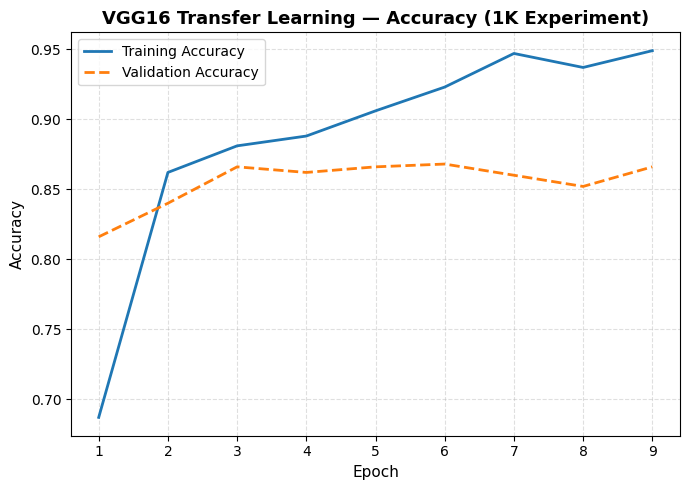

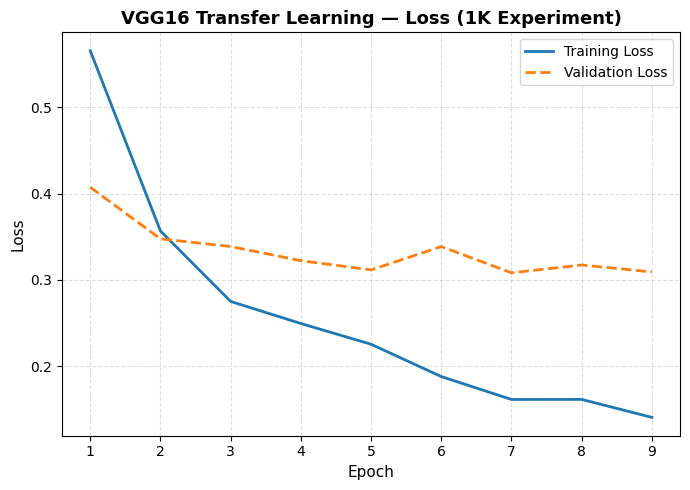

In [115]:
import matplotlib.pyplot as plt

h = history_tl_small.history
epochs = range(1, len(h['accuracy']) + 1)

# --- Accuracy ---
plt.figure(figsize=(7, 5))
plt.plot(epochs, h['accuracy'], label='Training Accuracy', linewidth=2)
plt.plot(epochs, h['val_accuracy'], label='Validation Accuracy', linewidth=2, linestyle='--')
plt.title('VGG16 Transfer Learning — Accuracy (1K Experiment)', fontsize=13, fontweight='bold')
plt.xlabel('Epoch', fontsize=11)
plt.ylabel('Accuracy', fontsize=11)
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()

# --- Loss ---
plt.figure(figsize=(7, 5))
plt.plot(epochs, h['loss'], label='Training Loss', linewidth=2)
plt.plot(epochs, h['val_loss'], label='Validation Loss', linewidth=2, linestyle='--')
plt.title('VGG16 Transfer Learning — Loss (1K Experiment)', fontsize=13, fontweight='bold')
plt.xlabel('Epoch', fontsize=11)
plt.ylabel('Loss', fontsize=11)
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()

**Evaluation Metrics — Confusion Matrix and Classification Report (VGG16, 1K)**

In [116]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# Predictions
probs_tl_s = model_tl_small.predict(test_gen_tl, verbose=0).ravel()
preds_tl_s = (probs_tl_s >= 0.5).astype(int)
true = test_gen_tl.classes

# Confusion matrix and report
cm_tl_s = confusion_matrix(true, preds_tl_s)
report_tl_s = classification_report(true, preds_tl_s, target_names=['cat', 'dog'])

# Display results
print("Confusion Matrix (Transfer Learning — 1K Experiment):\n", cm_tl_s)
print("\nClassification Report (Transfer Learning — 1K Experiment):\n", report_tl_s)


Confusion Matrix (Transfer Learning — 1K Experiment):
 [[215  35]
 [ 14 236]]

Classification Report (Transfer Learning — 1K Experiment):
               precision    recall  f1-score   support

         cat       0.94      0.86      0.90       250
         dog       0.87      0.94      0.91       250

    accuracy                           0.90       500
   macro avg       0.90      0.90      0.90       500
weighted avg       0.90      0.90      0.90       500



**Image Generators — VGG16 Transfer Learning (Experiment B: 10K)**

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = (150, 150)
BATCH = 32
ROOT_MED = "/content/data_medium"   # has train/ (5k cats + 5k dogs)
VAL_DIR  = "/content/data_small/val"
TEST_DIR = "/content/data_small/test"

base_datagen = ImageDataGenerator(rescale=1./255)

train_gen_tl_med = base_datagen.flow_from_directory(
    f"{ROOT_MED}/train", target_size=IMG_SIZE, batch_size=BATCH,
    class_mode='binary', shuffle=True
)
val_gen_tl = base_datagen.flow_from_directory(
    VAL_DIR, target_size=IMG_SIZE, batch_size=BATCH,
    class_mode='binary', shuffle=False
)
test_gen_tl = base_datagen.flow_from_directory(
    TEST_DIR, target_size=IMG_SIZE, batch_size=BATCH,
    class_mode='binary', shuffle=False
)


Found 10000 images belonging to 2 classes.
Found 500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


**Define Model B — VGG16 Transfer Learning (Experiment B: 10K)**

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models, optimizers

conv_base_med = VGG16(weights='imagenet', include_top=False, input_shape=(*IMG_SIZE, 3))
conv_base_med.trainable = False

model_tl_med = models.Sequential([
    conv_base_med,
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(256, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model_tl_med.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model_tl_med.summary()


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,812,353 (64.13 MB)

 Trainable params: 2,097,665 (8.00 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

**Train Model B — VGG16 Transfer Learning (Experiment B: 10K)**

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

ckpt_tl_med = "/content/model_tl_med_best.keras"
callbacks_tl_med = [
    EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True),
    ModelCheckpoint(ckpt_tl_med, monitor='val_accuracy', save_best_only=True)
]

history_tl_med = model_tl_med.fit(
    train_gen_tl_med,
    validation_data=val_gen_tl,
    epochs=10,
    callbacks=callbacks_tl_med,
    verbose=1
)


Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


313/313 ━━━━━━━━━━━━━━━━━━━━ 23s 65ms/step - accuracy: 0.7944 - loss: 0.4185 - val_accuracy: 0.9200 - val_loss: 0.2108
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 16s 51ms/step - accuracy: 0.8887 - loss: 0.2646 - val_accuracy: 0.9280 - val_loss: 0.1784
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 16s 52ms/step - accuracy: 0.9023 - loss: 0.2311 - val_accuracy: 0.9440 - val_loss: 0.1609
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 16s 51ms/step - accuracy: 0.9029 - loss: 0.2274 - val_accuracy: 0.9500 - val_loss: 0.1441
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 16s 51ms/step - accuracy: 0.9109 - loss: 0.2168 - val_accuracy: 0.9580 - val_loss: 0.1353
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 16s 50ms/step - accuracy: 0.9151 - loss: 0.2024 - val_accuracy: 0.9560 - val_loss: 0.1375
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 16s 50ms/step - accuracy: 0.9133 - loss: 0.2108 - val_accuracy: 0.9560 - val_loss: 0.1255
Epoch 8/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 16s 51ms/step - accuracy: 0.9258 - loss: 0.1820 - val_accurac

**Evaluate Model B — VGG16 Transfer Learning (Experiment B: 10K)**

In [ ]:
# Metrics
test_loss_tl_m, test_acc_tl_m = model_tl_med.evaluate(test_gen_tl, verbose=0)
val_acc_tl_m = max(history_tl_med.history['val_accuracy'])
print(f"[TL (VGG16), 10k train] Best Val Acc: {val_acc_tl_m:.3f}")
print(f"[TL (VGG16), 10k train] Test Acc:    {test_acc_tl_m:.3f}")

results_expt5 = {
    "model": "pretrained_vgg16",
    "train_samples": 10000,
    "val_samples": 500,
    "test_samples": 500,
    "val_acc": float(val_acc_tl_m),
    "test_acc": float(test_acc_tl_m)
}
results_expt5


[TL (VGG16), 10k train] Best Val Acc: 0.968
[TL (VGG16), 10k train] Test Acc:    0.974


{'model': 'pretrained_vgg16',
 'train_samples': 10000,
 'val_samples': 500,
 'test_samples': 500,
 'val_acc': 0.9679999947547913,
 'test_acc': 0.9739999771118164}

**Training Curves — VGG16 Transfer Learning (10K Experiment)**

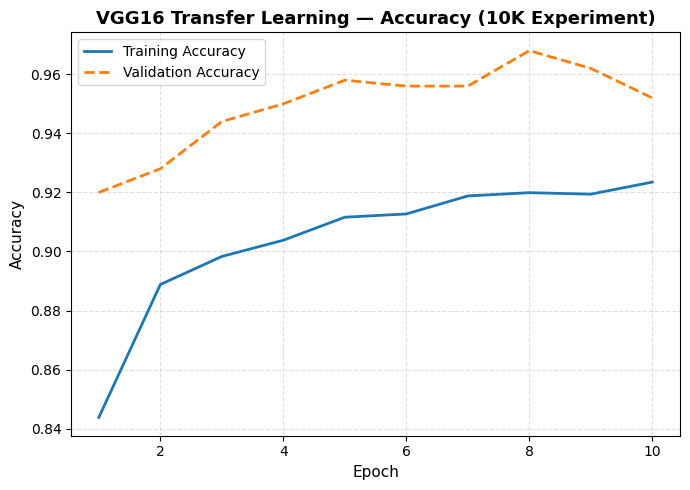

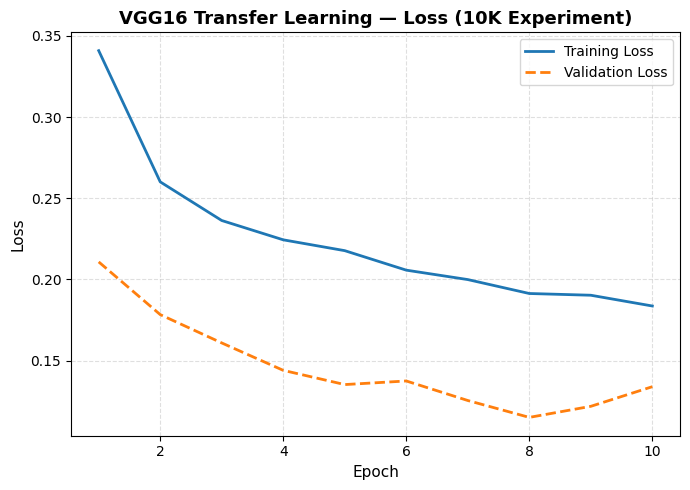

In [117]:
import matplotlib.pyplot as plt

h = history_tl_med.history
epochs = range(1, len(h['accuracy']) + 1)

# --- Accuracy ---
plt.figure(figsize=(7, 5))
plt.plot(epochs, h['accuracy'], label='Training Accuracy', linewidth=2)
plt.plot(epochs, h['val_accuracy'], label='Validation Accuracy', linewidth=2, linestyle='--')
plt.title('VGG16 Transfer Learning — Accuracy (10K Experiment)', fontsize=13, fontweight='bold')
plt.xlabel('Epoch', fontsize=11)
plt.ylabel('Accuracy', fontsize=11)
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()

# --- Loss ---
plt.figure(figsize=(7, 5))
plt.plot(epochs, h['loss'], label='Training Loss', linewidth=2)
plt.plot(epochs, h['val_loss'], label='Validation Loss', linewidth=2, linestyle='--')
plt.title('VGG16 Transfer Learning — Loss (10K Experiment)', fontsize=13, fontweight='bold')
plt.xlabel('Epoch', fontsize=11)
plt.ylabel('Loss', fontsize=11)
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()

**Evaluation Metrics — Confusion Matrix and Classification Report (VGG16, 10K)**

In [ ]:
# Confusion matrix & classification report
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

probs_tl_m = model_tl_med.predict(test_gen_tl, verbose=0).ravel()
preds_tl_m = (probs_tl_m >= 0.5).astype(int)
true = test_gen_tl.classes

cm_tl_m = confusion_matrix(true, preds_tl_m)
print("Confusion Matrix (TL 10k train):\n", cm_tl_m)
print("\nClassification Report (TL 10k train):\n",
      classification_report(true, preds_tl_m, target_names=['cat','dog']))


Confusion Matrix (TL 10k train):
 [[246   4]
 [  9 241]]

Classification Report (TL 10k train):
               precision    recall  f1-score   support

         cat       0.96      0.98      0.97       250
         dog       0.98      0.96      0.97       250

    accuracy                           0.97       500
   macro avg       0.97      0.97      0.97       500
weighted avg       0.97      0.97      0.97       500



**Image Generators — VGG16 Transfer Learning (Experiment C: 15K)**

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = (150, 150)
BATCH = 32
ROOT_15K = "/content/data_15k"
VAL_DIR  = "/content/data_small/val"
TEST_DIR = "/content/data_small/test"

base_datagen = ImageDataGenerator(rescale=1./255)

train_gen_tl_15k = base_datagen.flow_from_directory(
    f"{ROOT_15K}/train", target_size=IMG_SIZE, batch_size=BATCH,
    class_mode='binary', shuffle=True
)
val_gen_tl = base_datagen.flow_from_directory(
    VAL_DIR, target_size=IMG_SIZE, batch_size=BATCH,
    class_mode='binary', shuffle=False
)
test_gen_tl = base_datagen.flow_from_directory(
    TEST_DIR, target_size=IMG_SIZE, batch_size=BATCH,
    class_mode='binary', shuffle=False
)


Found 15000 images belonging to 2 classes.
Found 500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


**Train Model B — VGG16 Transfer Learning (Experiment C: 15K)**

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

conv_base_15k = VGG16(weights='imagenet', include_top=False, input_shape=(*IMG_SIZE, 3))
conv_base_15k.trainable = False

model_tl_15k = models.Sequential([
    conv_base_15k,
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(256, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model_tl_15k.compile(optimizer=optimizers.Adam(1e-4),
                     loss='binary_crossentropy', metrics=['accuracy'])

ckpt_tl_15k = "/content/model_tl_15k_best.keras"
callbacks_tl_15k = [
    EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True),
    ModelCheckpoint(ckpt_tl_15k, monitor='val_accuracy', save_best_only=True)
]

history_tl_15k = model_tl_15k.fit(
    train_gen_tl_15k, validation_data=val_gen_tl,
    epochs=10, callbacks=callbacks_tl_15k, verbose=1
)


Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 29s 56ms/step - accuracy: 0.7979 - loss: 0.4122 - val_accuracy: 0.9260 - val_loss: 0.2070
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 24s 50ms/step - accuracy: 0.8905 - loss: 0.2520 - val_accuracy: 0.9320 - val_loss: 0.1793
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 23s 49ms/step - accuracy: 0.8983 - loss: 0.2380 - val_accuracy: 0.9120 - val_loss: 0.1878
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 23s 50ms/step - accuracy: 0.9058 - loss: 0.2251 - val_accuracy: 0.9440 - val_loss: 0.1612
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 23s 50ms/step - accuracy: 0.9068 - loss: 0.2182 - val_accuracy: 0.9480 - val_loss: 0.1637
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 23s 49ms/step - accuracy: 0.9093 - loss: 0.2178 - val_accuracy: 0.9520 - val_loss: 0.1404
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 24s 50ms/step - accuracy: 0.9140 - loss: 0.2051 - val_accuracy: 0.9620 - val_loss: 0.1324
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 23s 48ms/step - accuracy: 0.9123 - loss: 0.2057 - 

**Evaluate Model B — VGG16 Transfer Learning (Experiment C: 15K)**

In [118]:
# Evaluate on test set
test_loss_tl_15k, test_acc_tl_15k = model_tl_15k.evaluate(test_gen_tl, verbose=0)
val_acc_tl_15k = max(history_tl_15k.history['val_accuracy'])

print(f"[Transfer Learning (VGG16), 15K Train] Best Validation Accuracy: {val_acc_tl_15k:.3f}")
print(f"[Transfer Learning (VGG16), 15K Train] Test Accuracy:            {test_acc_tl_15k:.3f}")

# Store results for later report
results_expt6 = {
    "model": "pretrained_vgg16",
    "train_samples": 15000,
    "val_samples": 500,
    "test_samples": 500,
    "val_acc": float(val_acc_tl_15k),
    "test_acc": float(test_acc_tl_15k)
}

results_expt6

[Transfer Learning (VGG16), 15K Train] Best Validation Accuracy: 0.974
[Transfer Learning (VGG16), 15K Train] Test Accuracy:            0.958


{'model': 'pretrained_vgg16',
 'train_samples': 15000,
 'val_samples': 500,
 'test_samples': 500,
 'val_acc': 0.9739999771118164,
 'test_acc': 0.9580000042915344}

**Training Curves — VGG16 Transfer Learning (15K Experiment)**

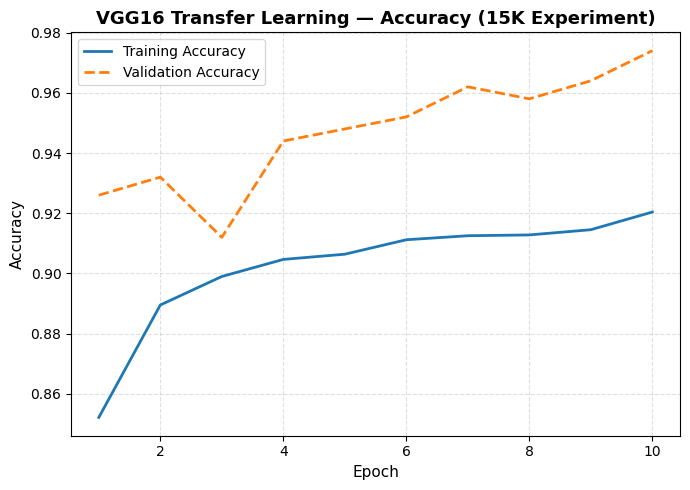

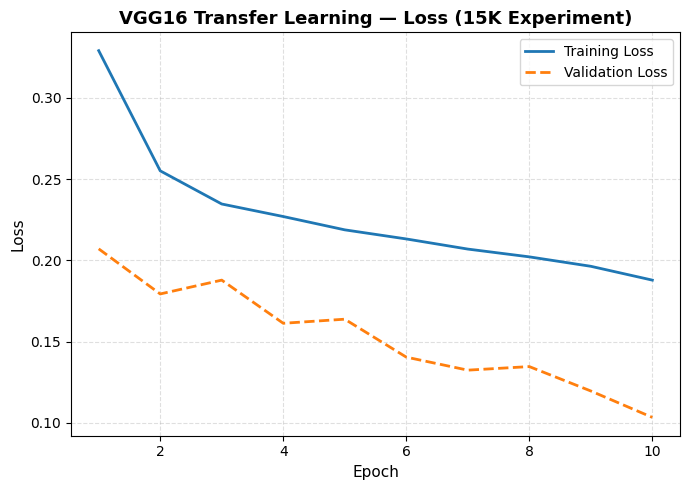

In [119]:
import matplotlib.pyplot as plt

h = history_tl_15k.history
epochs = range(1, len(h['accuracy']) + 1)

# --- Accuracy ---
plt.figure(figsize=(7, 5))
plt.plot(epochs, h['accuracy'], label='Training Accuracy', linewidth=2)
plt.plot(epochs, h['val_accuracy'], label='Validation Accuracy', linewidth=2, linestyle='--')
plt.title('VGG16 Transfer Learning — Accuracy (15K Experiment)', fontsize=13, fontweight='bold')
plt.xlabel('Epoch', fontsize=11)
plt.ylabel('Accuracy', fontsize=11)
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()

# --- Loss ---
plt.figure(figsize=(7, 5))
plt.plot(epochs, h['loss'], label='Training Loss', linewidth=2)
plt.plot(epochs, h['val_loss'], label='Validation Loss', linewidth=2, linestyle='--')
plt.title('VGG16 Transfer Learning — Loss (15K Experiment)', fontsize=13, fontweight='bold')
plt.xlabel('Epoch', fontsize=11)
plt.ylabel('Loss', fontsize=11)
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()

**Evaluation Metrics — Confusion Matrix and Classification Report (VGG16, 15K)**

In [121]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# Predictions on test data
probs_tl_15k = model_tl_15k.predict(test_gen_tl, verbose=0).ravel()
preds_tl_15k = (probs_tl_15k >= 0.5).astype(int)
true = test_gen_tl.classes

# Compute confusion matrix and report
cm_tl_15k = confusion_matrix(true, preds_tl_15k)
report_tl_15k = classification_report(true, preds_tl_15k, target_names=['cat', 'dog'])

# Display results
print("Confusion Matrix (VGG16 Transfer Learning — 15K Experiment):\n", cm_tl_15k)
print("\nClassification Report (VGG16 Transfer Learning — 15K Experiment):\n", report_tl_15k)

Confusion Matrix (VGG16 Transfer Learning — 15K Experiment):
 [[247   3]
 [ 18 232]]

Classification Report (VGG16 Transfer Learning — 15K Experiment):
               precision    recall  f1-score   support

         cat       0.93      0.99      0.96       250
         dog       0.99      0.93      0.96       250

    accuracy                           0.96       500
   macro avg       0.96      0.96      0.96       500
weighted avg       0.96      0.96      0.96       500



**Image Generators — VGG16 Transfer Learning (Experiment D: 20K)**

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = (150, 150)
BATCH = 32
ROOT_LARGE = "/content/data_large"   # has train/ (10k cats + 10k dogs)
VAL_DIR    = "/content/data_small/val"
TEST_DIR   = "/content/data_small/test"

base_datagen = ImageDataGenerator(rescale=1./255)

train_gen_tl_large = base_datagen.flow_from_directory(
    f"{ROOT_LARGE}/train", target_size=IMG_SIZE, batch_size=BATCH,
    class_mode='binary', shuffle=True
)
val_gen_tl = base_datagen.flow_from_directory(
    VAL_DIR, target_size=IMG_SIZE, batch_size=BATCH,
    class_mode='binary', shuffle=False
)
test_gen_tl = base_datagen.flow_from_directory(
    TEST_DIR, target_size=IMG_SIZE, batch_size=BATCH,
    class_mode='binary', shuffle=False
)


Found 20000 images belonging to 2 classes.
Found 500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


**Define Model B — VGG16 Transfer Learning (Experiment D: 20K)**

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models, optimizers

conv_base_l = VGG16(weights='imagenet', include_top=False, input_shape=(*IMG_SIZE, 3))
conv_base_l.trainable = False  # freeze

model_tl_large = models.Sequential([
    conv_base_l,
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(256, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model_tl_large.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model_tl_large.summary()


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,812,353 (64.13 MB)

 Trainable params: 2,097,665 (8.00 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

**Train Model B — VGG16 Transfer Learning (Experiment D: 20K)**

In [124]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Checkpoint path
ckpt_tl_large = "/content/model_tl_large_best.keras"

# Callbacks for early stopping and best model saving
callbacks_tl_large = [
    EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True),
    ModelCheckpoint(ckpt_tl_large, monitor='val_accuracy', save_best_only=True)
]

# Train model
history_tl_large = model_tl_large.fit(
    train_gen_tl_large,
    validation_data=val_gen_tl,
    epochs=10,  # TL converges quickly
    callbacks=callbacks_tl_large,
    verbose=1
)


Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 31s 49ms/step - accuracy: 0.9430 - loss: 0.1364 - val_accuracy: 0.9860 - val_loss: 0.0730
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 30s 48ms/step - accuracy: 0.9481 - loss: 0.1268 - val_accuracy: 0.9740 - val_loss: 0.0888
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 30s 48ms/step - accuracy: 0.9499 - loss: 0.1260 - val_accuracy: 0.9860 - val_loss: 0.0673
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 32s 50ms/step - accuracy: 0.9543 - loss: 0.1143 - val_accuracy: 0.9940 - val_loss: 0.0514
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 30s 48ms/step - accuracy: 0.9553 - loss: 0.1099 - val_accuracy: 0.9960 - val_loss: 0.0487
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 31s 49ms/step - accuracy: 0.9603 - loss: 0.1003 - val_accuracy: 1.0000 - val_loss: 0.0463
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 31s 49ms/step - accuracy: 0.9645 - loss: 0.0952 - val_accuracy: 0.9960 - val_loss: 0.0342
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 30s 48ms/step - accuracy: 0.9649 - loss: 0.0919 - 

**Evaluate Model B — VGG16 Transfer Learning (Experiment D: 20K)**

In [142]:
# Metrics
test_loss_tl_l, test_acc_tl_l = model_tl_large.evaluate(test_gen_tl, verbose=0)
val_acc_tl_l = max(history_tl_large.history['val_accuracy'])
print(f"[TL (VGG16), 20k train] Best Val Acc: {val_acc_tl_l:.3f}")
print(f"[TL (VGG16), 20k train] Test Acc:    {test_acc_tl_l:.3f}")

results_expt6 = {
    "model": "pretrained_vgg16",
    "train_samples": 20000,
    "val_samples": 500,
    "test_samples": 500,
    "val_acc": float(val_acc_tl_l),
    "test_acc": float(test_acc_tl_l)
}
results_expt6


[TL (VGG16), 20k train] Best Val Acc: 1.000
[TL (VGG16), 20k train] Test Acc:    0.998


{'model': 'pretrained_vgg16',
 'train_samples': 20000,
 'val_samples': 500,
 'test_samples': 500,
 'val_acc': 1.0,
 'test_acc': 0.9980000257492065}

**Training Curves — VGG16 Transfer Learning (20K Experiment)**

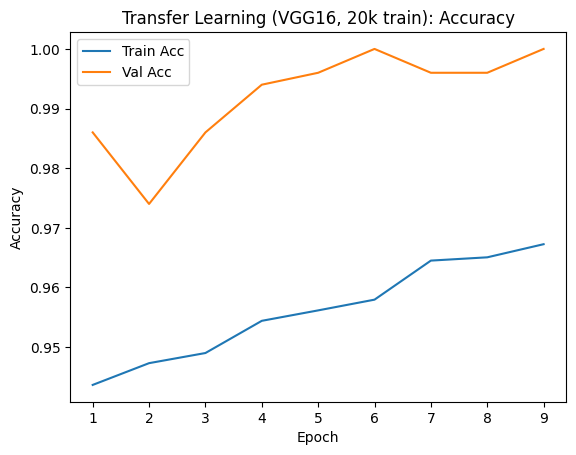

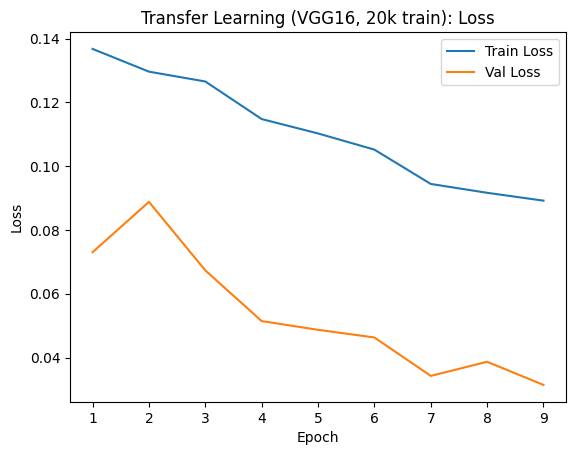

In [143]:
# Plots
import matplotlib.pyplot as plt
h = history_tl_large.history
epochs = range(1, len(h['accuracy'])+1)

plt.figure()
plt.plot(epochs, h['accuracy'], label='Train Acc')
plt.plot(epochs, h['val_accuracy'], label='Val Acc')
plt.title('Transfer Learning (VGG16, 20k train): Accuracy')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend(); plt.show()

plt.figure()
plt.plot(epochs, h['loss'], label='Train Loss')
plt.plot(epochs, h['val_loss'], label='Val Loss')
plt.title('Transfer Learning (VGG16, 20k train): Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.show()


**Evaluation Metrics — Confusion Matrix and Classification Report (VGG16, 20K)**

In [144]:
# Confusion matrix & classification report
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

probs_tl_l = model_tl_large.predict(test_gen_tl, verbose=0).ravel()
preds_tl_l = (probs_tl_l >= 0.5).astype(int)
true = test_gen_tl.classes

cm_tl_l = confusion_matrix(true, preds_tl_l)
print("Confusion Matrix (TL 20k train):\n", cm_tl_l)
print("\nClassification Report (TL 20k train):\n",
      classification_report(true, preds_tl_l, target_names=['cat','dog']))


Confusion Matrix (TL 20k train):
 [[250   0]
 [  1 249]]

Classification Report (TL 20k train):
               precision    recall  f1-score   support

         cat       1.00      1.00      1.00       250
         dog       1.00      1.00      1.00       250

    accuracy                           1.00       500
   macro avg       1.00      1.00      1.00       500
weighted avg       1.00      1.00      1.00       500



**Aggregate VGG16 Transfer Learning Results Across All Experiments**

In [145]:
import pandas as pd

# Collect all experiment result dictionaries
candidates_tl = []
for name in ["results_expt4", "results_expt5", "results_expt6", "results_expt8"]:
    if name in globals():
        candidates_tl.append(globals()[name])

# Build and sort the summary table
results_df_tl = pd.DataFrame(candidates_tl)
results_df_tl = results_df_tl.sort_values("train_samples").reset_index(drop=True)

# Display neatly rounded results
display(results_df_tl.round(3))

# Save the summary table
results_df_tl.to_csv("/content/results_summary_transfer_learning.csv", index=False)
print("Saved summary: /content/results_summary_transfer_learning.csv")

,model,train_samples,val_samples,test_samples,val_acc,test_acc
0,pretrained_vgg16,1000,500,500,0.868,0.902
1,pretrained_vgg16,10000,500,500,0.968,0.974
2,pretrained_vgg16,15000,500,500,0.974,0.958
3,pretrained_vgg16,20000,500,500,1.000,0.998


Saved summary: /content/results_summary_transfer_learning.csv


**Final Results Summary — From-Scratch vs VGG16 Transfer Learning (1K–20K)**

In [146]:

import pandas as pd

# Collect all result dictionaries
all_results = []

for name in [
    "results_expt1", "results_expt2", "results_expt3",          # From-Scratch 1K, 10K, 15K
    "results_expt7", "results_expt4", "results_expt5",           # 15K fix (if any), TL 1K, TL 10K
    "results_expt6", "results_expt8"                             # TL 15K, TL 20K
]:
    if name in globals():
        all_results.append(globals()[name])

# Build DataFrame
final_df = pd.DataFrame(all_results)
final_df = final_df.sort_values(["model", "train_samples"]).reset_index(drop=True)

# Rename models for clarity
final_df['Model'] = final_df['model'].replace({
    'from_scratch': 'CNN (From Scratch)',
    'pretrained_vgg16': 'VGG16 (Transfer Learning)'
})

# Organize and format columns
final_df = final_df[['Model', 'train_samples', 'val_acc', 'test_acc']]
final_df = final_df.rename(columns={
    'train_samples': 'Training Samples',
    'val_acc': 'Validation Accuracy',
    'test_acc': 'Test Accuracy'
})

# Convert to percentage form
final_df['Validation Accuracy'] = (final_df['Validation Accuracy'] * 100).round(2)
final_df['Test Accuracy'] = (final_df['Test Accuracy'] * 100).round(2)

# Display formatted table
print("✅ Final Results Summary: From-Scratch vs Transfer Learning\n")
display(final_df.style.set_caption("Model Performance Comparison (1K–20K)")
        .set_table_styles([{'selector': 'caption', 'props': [('font-size', '14pt'), ('font-weight', 'bold')]}])
        .format({'Validation Accuracy': '{:.2f}%', 'Test Accuracy': '{:.2f}%'}))

✅ Final Results Summary: From-Scratch vs Transfer Learning



,Model,Training Samples,Validation Accuracy,Test Accuracy
0,CNN (From Scratch),1000,70.60%,74.00%
1,CNN (From Scratch),10000,85.60%,84.20%
2,CNN (From Scratch),15000,87.60%,86.00%
3,CNN (From Scratch),20000,87.20%,87.60%
4,VGG16 (Transfer Learning),1000,86.80%,90.20%
5,VGG16 (Transfer Learning),10000,96.80%,97.40%
6,VGG16 (Transfer Learning),15000,97.40%,95.80%
7,VGG16 (Transfer Learning),20000,100.00%,99.80%


**Performance Comparison — From-Scratch vs VGG16 Transfer Learning**

In [147]:


import numpy as np
import pandas as pd

# Collect results
names = [
    "results_expt1","results_expt2","results_expt3","results_expt7",
    "results_expt4","results_expt5","results_expt6","results_expt8"
]
rows = []
for n in names:
    if n in globals():
        r = globals()[n].copy()
        r["name"] = n
        rows.append(r)

df = pd.DataFrame(rows)
if df.empty:
    raise RuntimeError("No results_expt* dicts found. Run the evaluation cells first.")

# Normalize / clean
df["model_type"] = df["model"].map({
    "from_scratch":"From Scratch",
    "pretrained_vgg16":"Pretrained (VGG16)"
}).fillna(df["model"])

df = df.dropna(subset=["test_acc"]).copy()
df["train_samples"] = df["train_samples"].astype(int)
df["val_acc"] = (df["val_acc"]*100).round(2)
df["test_acc"] = (df["test_acc"]*100).round(2)

# If there are multiple rows for the same (model_type, train_samples),
# keep the one with the best test_acc so downstream lookups are unique.
df = (df.sort_values("test_acc", ascending=False)
        .groupby(["model_type","train_samples"], as_index=False)
        .first())

# ----- helpers -----
def scalar(series):
    """Return a Python float from a 1-element Series, else np.nan."""
    if len(series) == 0:
        return np.nan
    return float(series.iloc[0])

def acc_at(model_type, n):
    s = df.loc[(df["model_type"]==model_type) & (df["train_samples"]==n), "test_acc"]
    return scalar(s)

def best_row(g):
    # highest test_acc; if tie, smallest training size
    g2 = g.sort_values(["test_acc","train_samples"], ascending=[False, True])
    return g2.iloc[0]

def pct(x):
    return f"{x:.2f}%" if np.isfinite(x) else "n/a"

# ---------- 1) Optimal training sizes ----------
print("1. OPTIMAL TRAINING SIZES:\n")
for m, g in df.groupby("model_type", sort=False):
    b = best_row(g)
    print(f"{m.upper()}:")
    print(f"- Optimal Training Size: {int(b['train_samples']):,} samples")
    print(f"- Test Accuracy: {pct(float(b['test_acc']))}")
    print(f"- Experiment: {b['name']}\n")

# ---------- 2) Impact of training data size (1K vs 10K) ----------
print("2. IMPACT OF TRAINING DATA SIZE (1,000 vs 10,000 samples):\n")
for m in ["From Scratch", "Pretrained (VGG16)"]:
    a1 = acc_at(m, 1000)
    a2 = acc_at(m, 10000)
    if np.isfinite(a1) and np.isfinite(a2):
        diff = a2 - a1
        rel = (diff / a1 * 100.0) if a1 > 0 else np.nan
        print(f"{m}:")
        print(f"- 1,000 samples: {pct(a1)}")
        print(f"- 10,000 samples: {pct(a2)}")
        print(f"- Improvement: +{diff:.2f} percentage points ({rel:.1f}% relative increase)\n")
    else:
        print(f"{m}: insufficient results for 1K→10K comparison.\n")

# ---------- 3) From-Scratch vs Pretrained comparison at shared sizes ----------
print("3. FROM SCRATCH VS PRETRAINED COMPARISON:\n")
shared = sorted(
    set(df.loc[df["model_type"]=="From Scratch","train_samples"])
    & set(df.loc[df["model_type"]=="Pretrained (VGG16)","train_samples"])
)
for n in shared:
    a_fs = acc_at("From Scratch", n)
    a_tl = acc_at("Pretrained (VGG16)", n)
    if np.isfinite(a_fs) and np.isfinite(a_tl):
        adv = a_tl - a_fs
        leader = "Pretrained" if adv >= 0 else "From Scratch"
        print(f"Training Size: {n:,} samples")
        print(f"- From Scratch:  {pct(a_fs)}")
        print(f"- Pretrained:    {pct(a_tl)}")
        print(f"- Advantage:     {leader} by {abs(adv):.2f} percentage points\n")


1. OPTIMAL TRAINING SIZES:

FROM SCRATCH:
- Optimal Training Size: 20,000 samples
- Test Accuracy: 87.60%
- Experiment: results_expt3

PRETRAINED (VGG16):
- Optimal Training Size: 20,000 samples
- Test Accuracy: 99.80%
- Experiment: results_expt6

2. IMPACT OF TRAINING DATA SIZE (1,000 vs 10,000 samples):

From Scratch:
- 1,000 samples: 74.00%
- 10,000 samples: 84.20%
- Improvement: +10.20 percentage points (13.8% relative increase)

Pretrained (VGG16):
- 1,000 samples: 90.20%
- 10,000 samples: 97.40%
- Improvement: +7.20 percentage points (8.0% relative increase)

3. FROM SCRATCH VS PRETRAINED COMPARISON:

Training Size: 1,000 samples
- From Scratch:  74.00%
- Pretrained:    90.20%
- Advantage:     Pretrained by 16.20 percentage points

Training Size: 10,000 samples
- From Scratch:  84.20%
- Pretrained:    97.40%
- Advantage:     Pretrained by 13.20 percentage points

Training Size: 15,000 samples
- From Scratch:  86.00%
- Pretrained:    95.80%
- Advantage:     Pretrained by 9.80 perc

**Model Performance Dashboard**

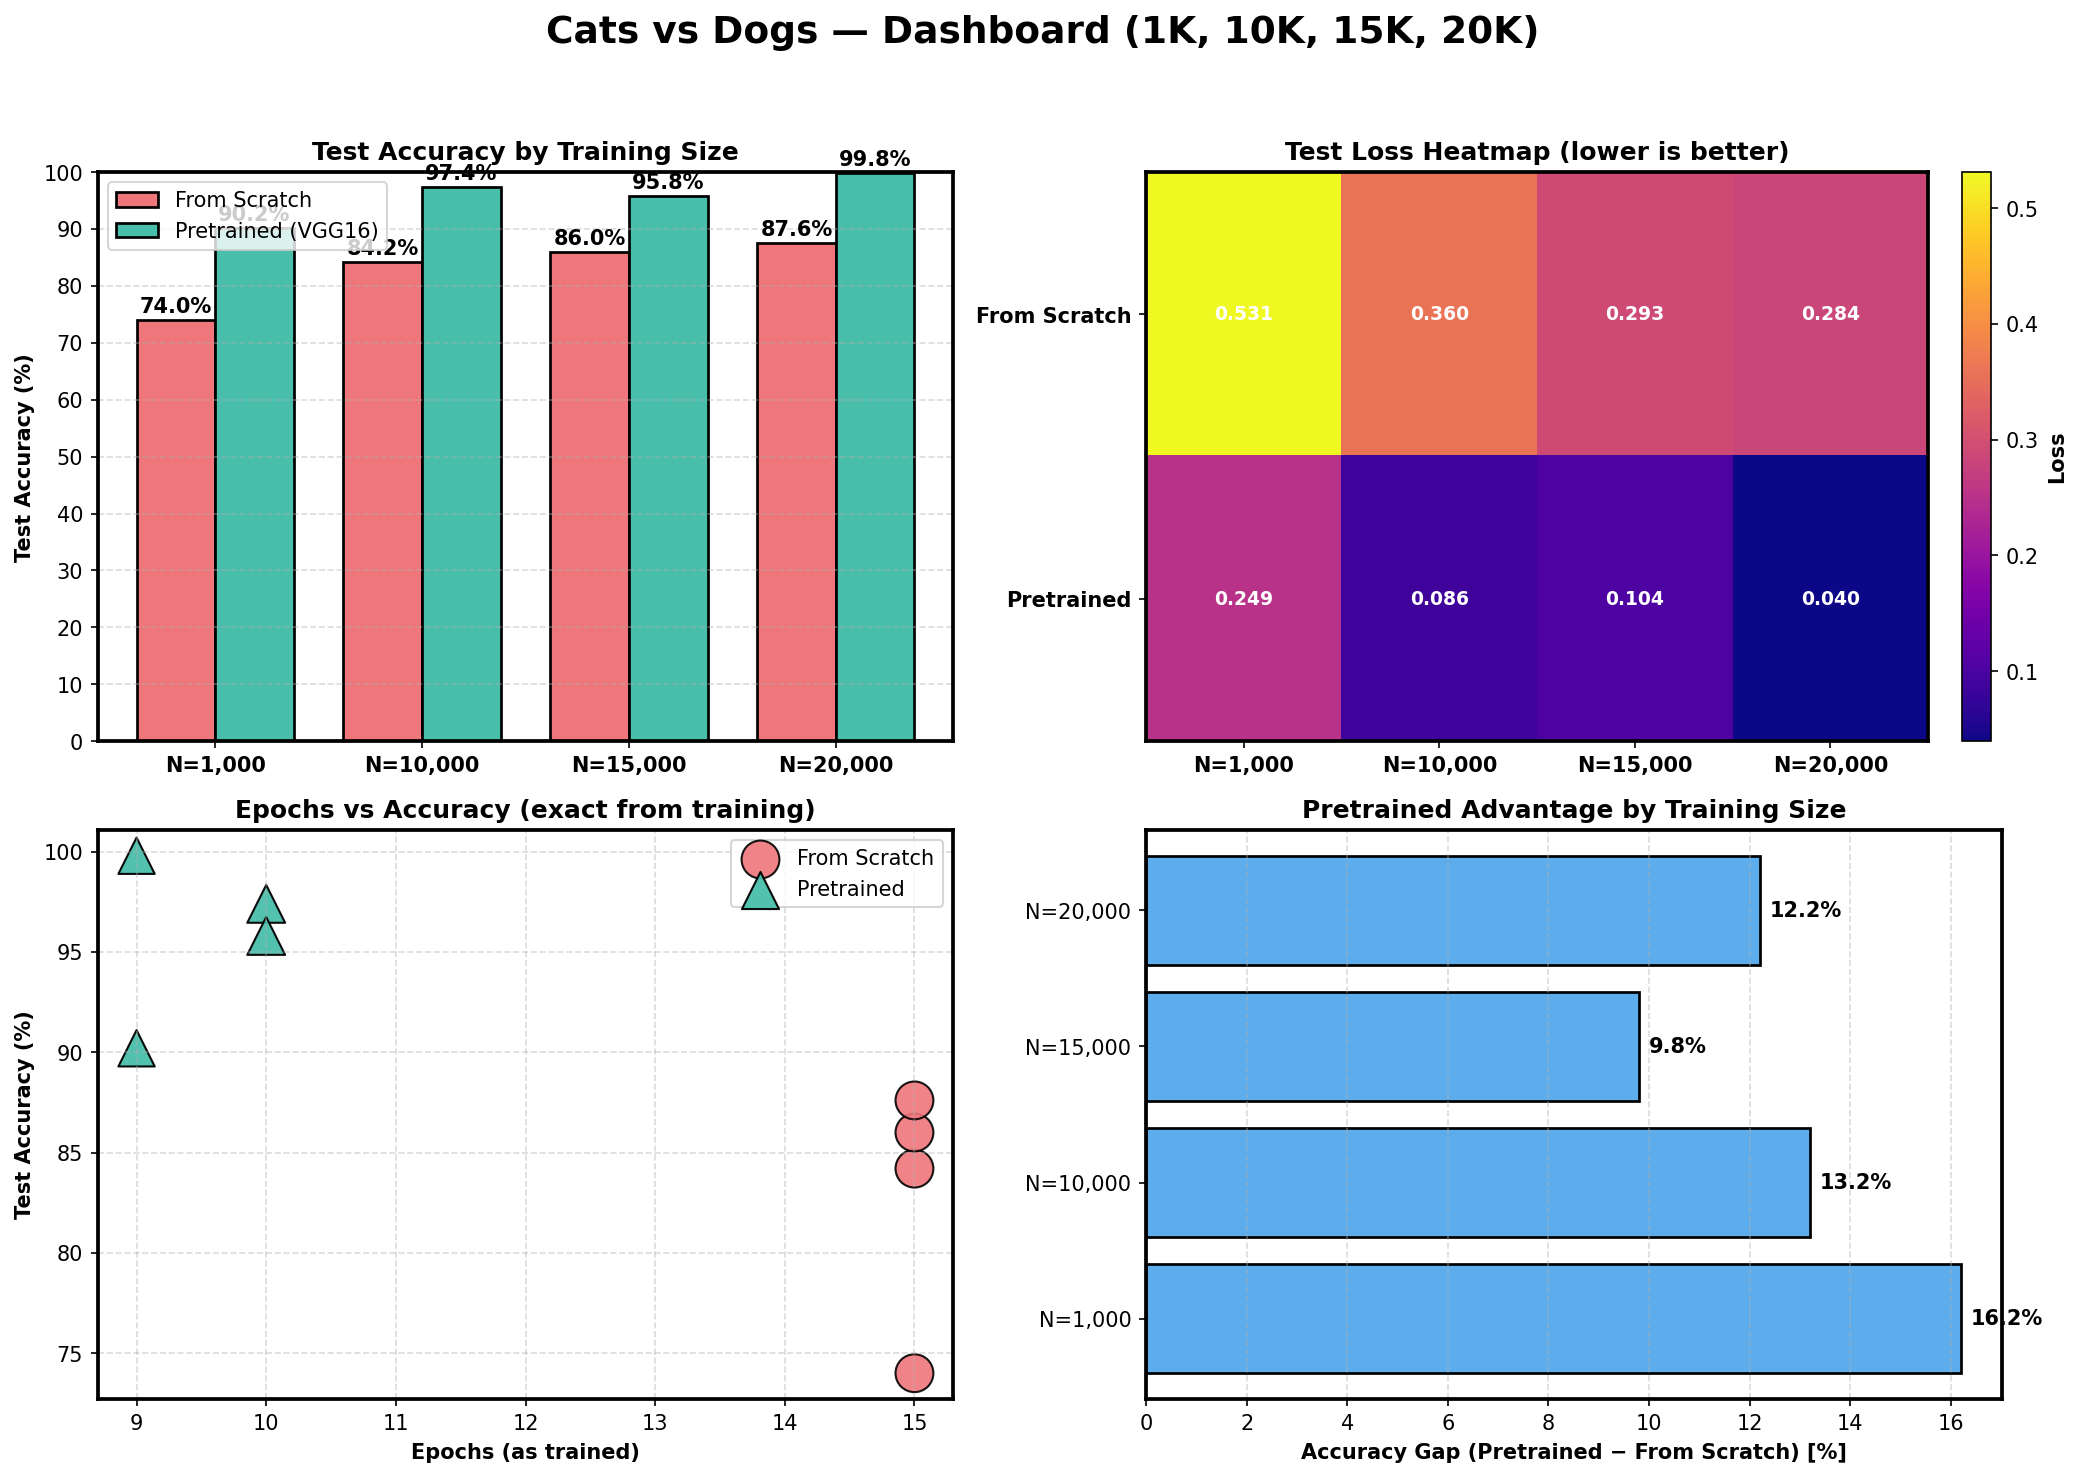

In [150]:
#
# Cats vs Dogs — Dashboard (1K, 10K, 15K, 20K)


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------- 0) Validate & normalize source ----------
if 'df' not in globals() or df.empty:
    raise RuntimeError("Dashboard needs 'df' from your results summary cell.")

src = df.copy()
src["Model"] = src["model_type"]                   # 'From Scratch' / 'Pretrained (VGG16)'
src["N"] = src["train_samples"].astype(int)

# Keep best row if duplicates exist for (Model, N)
src = (src.sort_values("test_acc", ascending=False)
          .groupby(["Model","N"], as_index=False)
          .first())

sizes = [1000, 10000, 15000, 20000]

# ---------- 1) Helpers ----------
def add_border(ax, lw=1.8):
    for s in ax.spines.values():
        s.set_edgecolor("black"); s.set_linewidth(lw)

def label_bars(ax, bars):
    for b in bars:
        h = b.get_height()
        if np.isfinite(h):
            ax.text(b.get_x()+b.get_width()/2, h+0.6, f"{h:.1f}%",
                    ha='center', va='bottom', fontsize=10, fontweight='bold')

def to_percent(arr_like):
    """Return values on 0–100 scale (auto-detect if already in %)."""
    s = pd.Series(arr_like).astype(float)
    mx = s.max(skipna=True)
    return (s*100.0).values if (pd.notna(mx) and mx <= 1.5) else s.values

def vec(model, col):
    out = []
    for n in sizes:
        s = src[(src["Model"]==model) & (src["N"]==n)][col]
        out.append(float(s.iloc[0]) if len(s) else np.nan)
    return np.array(out, dtype=float)

# ---------- 2) Build vectors ----------
# Accuracies (auto-normalize to %)
fs_acc = to_percent(vec("From Scratch", "test_acc"))
tl_acc = to_percent(vec("Pretrained (VGG16)", "test_acc"))

# Epochs (exact counts from histories if available)
history_map = {
    ("From Scratch",        1000):  globals().get("history_scratch"),
    ("From Scratch",       10000):  globals().get("history_scratch_med"),
    ("From Scratch",       15000):  globals().get("history_scratch_15k"),
    ("From Scratch",       20000):  globals().get("history_scratch_large"),
    ("Pretrained (VGG16)",  1000):  globals().get("history_tl_small"),
    ("Pretrained (VGG16)", 10000):  globals().get("history_tl_med"),
    ("Pretrained (VGG16)", 15000):  globals().get("history_tl_15k"),
    ("Pretrained (VGG16)", 20000):  globals().get("history_tl_large"),
}
def epochs_of(model, n):
    h = history_map.get((model, n))
    if h is None: return np.nan
    for k in ("accuracy","acc","binary_accuracy"):
        if k in h.history:
            return len(h.history[k])
    return np.nan

fs_ep = np.array([epochs_of("From Scratch", n) for n in sizes], dtype=float)
tl_ep = np.array([epochs_of("Pretrained (VGG16)", n) for n in sizes], dtype=float)

# Optional losses (heatmap shows '—' if missing)
loss_vars = {
    ("From Scratch",        1000):  "test_loss",
    ("From Scratch",       10000):  "test_loss_med",
    ("From Scratch",       15000):  "test_loss_15k",
    ("From Scratch",       20000):  "test_loss_l",
    ("Pretrained (VGG16)",  1000):  "test_loss_tl_s",
    ("Pretrained (VGG16)", 10000):  "test_loss_tl_m",
    ("Pretrained (VGG16)", 15000):  "test_loss_tl_15k",
    ("Pretrained (VGG16)", 20000):  "test_loss_tl_l",
}
def loss_of(model, n):
    v = loss_vars.get((model, n))
    if v and v in globals():
        try: return float(globals()[v])
        except: pass
    return np.nan

fs_loss = np.array([loss_of("From Scratch", n) for n in sizes], dtype=float)
tl_loss = np.array([loss_of("Pretrained (VGG16)", n) for n in sizes], dtype=float)

# ---------- 3) Plot ----------
plt.close('all')
fig = plt.figure(figsize=(14,10), dpi=150)
fig.suptitle("Cats vs Dogs — Dashboard (1K, 10K, 15K, 20K)", fontsize=18, fontweight='bold', y=0.98)

# (A) Accuracy vs Training Size
ax1 = plt.subplot2grid((2,2),(0,0))
x = np.arange(len(sizes)); w = 0.38
b1 = ax1.bar(x-w/2, fs_acc, width=w, color="#EF767A", edgecolor="black", linewidth=1.3, label="From Scratch")
b2 = ax1.bar(x+w/2, tl_acc, width=w, color="#49BEAA", edgecolor="black", linewidth=1.3, label="Pretrained (VGG16)")
label_bars(ax1, b1); label_bars(ax1, b2)
ax1.set_xticks(x); ax1.set_xticklabels([f"N={n:,}" for n in sizes], fontweight='bold')
ax1.set_ylim(0, 100); ax1.yaxis.set_major_locator(plt.MultipleLocator(10))
ax1.set_ylabel("Test Accuracy (%)", fontweight='bold')
ax1.set_title("Test Accuracy by Training Size", fontweight='bold')
ax1.grid(axis='y', linestyle='--', alpha=0.45); ax1.legend(frameon=True); add_border(ax1)

# (B) Test Loss Heatmap (lower is better)
ax2 = plt.subplot2grid((2,2),(0,1))
mat = np.vstack([fs_loss, tl_loss]).astype(float)
cmap = plt.cm.plasma.copy(); cmap.set_bad("#e6e6e6")
masked = np.ma.masked_invalid(mat)
if np.isfinite(mat).any():
    vmin, vmax = np.nanmin(mat), np.nanmax(mat)
else:
    vmin, vmax = 0.0, 1.0
im = ax2.imshow(masked, cmap=cmap, aspect='auto', vmin=vmin, vmax=vmax)
ax2.set_xticks(np.arange(len(sizes))); ax2.set_xticklabels([f"N={n:,}" for n in sizes], fontweight='bold')
ax2.set_yticks([0,1]); ax2.set_yticklabels(["From Scratch","Pretrained"], fontweight='bold')
ax2.set_title("Test Loss Heatmap (lower is better)", fontweight='bold')
for i in range(masked.shape[0]):
    for j in range(masked.shape[1]):
        v = mat[i,j]
        ax2.text(j, i, "—" if not np.isfinite(v) else f"{v:.3f}",
                 ha='center', va='center', color='white', fontsize=9, fontweight='bold')
cb = fig.colorbar(im, ax=ax2, fraction=0.046, pad=0.04); cb.set_label("Loss", fontweight='bold')
add_border(ax2)

# (C) Epochs vs Accuracy (exact epochs from training)
ax3 = plt.subplot2grid((2,2),(1,0))
fs_pts = [(e,a) for e,a in zip(fs_ep, fs_acc) if np.isfinite(e) and np.isfinite(a)]
tl_pts = [(e,a) for e,a in zip(tl_ep, tl_acc) if np.isfinite(e) and np.isfinite(a)]
if fs_pts:
    X,Y = zip(*fs_pts)
    ax3.scatter(X, Y, s=(np.array(X)/max(np.nanmax(fs_ep),1))*250+80,
                c="#EF767A", edgecolor='black', linewidth=1.0, alpha=0.9, label="From Scratch")
if tl_pts:
    X2,Y2 = zip(*tl_pts)
    ax3.scatter(X2, Y2, s=(np.array(X2)/max(np.nanmax(tl_ep),1))*250+80,
                c="#49BEAA", marker='^', edgecolor='black', linewidth=1.0, alpha=0.95, label="Pretrained")
ax3.set_xlabel("Epochs (as trained)", fontweight='bold')
ax3.set_ylabel("Test Accuracy (%)", fontweight='bold')
ax3.set_title("Epochs vs Accuracy (exact from training)", fontweight='bold')
ax3.grid(True, linestyle='--', alpha=0.45); ax3.legend(frameon=True); add_border(ax3)

# (D) Pretrained Advantage by Training Size
ax4 = plt.subplot2grid((2,2),(1,1))
gaps, labels = [], []
for n, a_fs, a_tl in zip(sizes, fs_acc, tl_acc):
    if np.isfinite(a_fs) and np.isfinite(a_tl):
        gaps.append(a_tl - a_fs); labels.append(f"N={n:,}")
bars = ax4.barh(labels, gaps, color="#5DADEC", edgecolor='black', linewidth=1.3)
for b, g in zip(bars, gaps):
    ax4.text(b.get_width()+0.2, b.get_y()+b.get_height()/2, f"{g:.1f}%", va='center', fontsize=10, fontweight='bold')
ax4.set_xlabel("Accuracy Gap (Pretrained − From Scratch) [%]", fontweight='bold')
ax4.set_title("Pretrained Advantage by Training Size", fontweight='bold')
ax4.grid(axis='x', linestyle='--', alpha=0.45); add_border(ax4)

plt.tight_layout(rect=[0,0,1,0.95])
# fig.savefig("/content/dashboard_1k_10k_15k_20k.png", dpi=220, bbox_inches="tight")
plt.show()
